In [158]:
import sys
import os

# 現在の作業ディレクトリを基にプロジェクトのルートディレクトリを設定
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.append(project_root)
print(project_root)

c:\Users\keisu\Desktop\研究元ファイル\abnormal


In [159]:
import sys
import pandas as pd
import numpy as np
from sklearn import svm
import scipy.stats
import matplotlib.pyplot as plt
import csv
import re
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import preprocessing
import datetime
from dfply import *
import random
import gc
plt.style.use('ggplot')
# pd.options.display.float_format = '{:.2f}'.format

データの読み込みを行う

In [34]:
# raw_dataのパスの作成
cache_dir = os.path.join(project_root, 'research_abnormal','cache')
cache_path_ECDIS = os.path.join(cache_dir, 'cached_data_raw_data_ECDIS.joblib')
cache_path_Radar = os.path.join(cache_dir, 'cached_data_raw_data_Radar.joblib')

In [36]:
raw_data_ECDIS = joblib.load(cache_path_ECDIS)
raw_data_Radar = joblib.load(cache_path_Radar)

ここではデータの読み込みと同時に新しいカラム、id、measurement_ymd（日付部分）、measurement_ymd_h（時間部分）measurement_ymd_hms(完全な日付と時間、分、秒)を作成する。

measurement_dataは観測した日時まで記録されているがこれを丸め込んで新たな日時データを作成している。

In [37]:
raw_data_ECDIS = raw_data_ECDIS >> mutate(id = X.f_shipno+"-"+X.equipment_label_no,
                         measurement_ymd = X.measurement_date.str[:10],
                         measurement_ymd_h = X.measurement_date.str[11:13]) >> mutate(
    measurement_ymd_hms = X.measurement_ymd+" "+X.measurement_ymd_h+":00:00")

In [40]:
print(raw_data_ECDIS["measurement_date"])

0          2020-06-03 07:54:06
1          2020-06-03 08:00:01
2          2020-06-03 09:00:02
3          2020-06-04 01:00:01
4          2020-06-04 02:00:01
                  ...         
2057533    2021-04-20 19:00:02
2057534    2021-04-20 20:00:01
2057535    2021-04-20 21:00:01
2057536    2021-04-20 22:00:02
2057537    2021-04-20 23:00:02
Name: measurement_date, Length: 2057538, dtype: object


In [41]:
raw_data_Radar = raw_data_Radar>> mutate(id = X.f_shipno+"-"+X.equipment_label_no,
                         measurement_ymd = X.measurement_date.str[:10],
                         measurement_ymd_h = X.measurement_date.str[11:13]) >> mutate(
    measurement_ymd_hms = X.measurement_ymd+" "+X.measurement_ymd_h+":00:00")

作成したデータの確認

In [42]:
raw_data_ECDIS.head(5)

equipment_label_no f_shipno      imono      shipnameen  \
0               4533  9883118  9883118.0  AFRICAN PARROT   
1               4533  9883118  9883118.0  AFRICAN PARROT   
2               4533  9883118  9883118.0  AFRICAN PARROT   
3               4533  9883118  9883118.0  AFRICAN PARROT   
4               4533  9883118  9883118.0  AFRICAN PARROT   

  monitored_equipment_category_name monitored_equipment_model_name  \
0                             ECDIS                       FMD-3x00   
1                             ECDIS                       FMD-3x00   
2                             ECDIS                       FMD-3x00   
3                             ECDIS                       FMD-3x00   
4                             ECDIS                       FMD-3x00   

      measurement_date service_gateway_date     system_date_time  \
0  2020-06-03 07:54:06  2020-06-03 07:54:06  2020-06-03 07:56:40   
1  2020-06-03 08:00:01  2020-06-03 08:00:01  2020-06-03 08:02:36   
2  2020-06-03 09:00:02  2020-06-03 09:00:02  2020-06-03 09:02:36   
3  2020-06-04 01:00:01  2020-06-04 01:00:01  2020-06-04 01:02:37   
4  2020-06-04 02:00:01  2020-06-04 02:00:01  2020-06-04 02:02:37   

   list_version  ... rcu3_units_status_main__timer_int_sta rcu3_units__unit  \
0             1  ...                                   NaN              NaN   
1             1  ...                                   NaN              NaN   
2             1  ...                                   NaN              NaN   
3             1  ...                                   NaN              NaN   
4             1  ...                                   NaN              NaN   

  rcu3_units__unit_name rcu3_units__unit_type           created_at  \
0                   NaN                   NaN  2020-06-03 08:01:24   
1                   NaN                   NaN  2020-06-03 08:11:22   
2                   NaN                   NaN  2020-06-03 09:08:51   
3                   NaN                   NaN  2020-06-04 15:39:03   
4                   NaN                   NaN  2020-06-04 02:08:51   

  is_hermace_data            id  measurement_ymd  measurement_ymd_h  \
0               f  9883118-4533       2020-06-03                 07   
1               f  9883118-4533       2020-06-03                 08   
2               f  9883118-4533       2020-06-03                 09   
3               f  9883118-4533       2020-06-04                 01   
4               f  9883118-4533       2020-06-04                 02   

   measurement_ymd_hms  
0  2020-06-03 07:00:00  
1  2020-06-03 08:00:00  
2  2020-06-03 09:00:00  
3  2020-06-04 01:00:00  
4  2020-06-04 02:00:00  

[5 rows x 145 columns]

In [171]:
raw_data_Radar.head()

equipment_label_no f_shipno    imono    shipnameen   \
0        7073         9863558  9863558.0  ALTERA WAVE   
1        7073         9863558  9863558.0  ALTERA WAVE   
2        7073         9863558  9863558.0  ALTERA WAVE   
3        7073         9863558  9863558.0  ALTERA WAVE   
4        7073         9863558  9863558.0  ALTERA WAVE   

  monitored_equipment_category_name monitored_equipment_model_name  \
0                Radar                         FAR-3xx0              
1                Radar                         FAR-3xx0              
2                Radar                         FAR-3xx0              
3                Radar                         FAR-3xx0              
4                Radar                         FAR-3xx0              

    measurement_date   service_gateway_date is_xml_data_format  \
0  2020-12-23 07:00:02  2020-12-23 07:00:02          f           
1  2020-12-23 08:00:01  2020-12-23 08:00:01          f           
2  2020-12-23 09:00:01  2020-12-23 09:00:01          f           
3  2020-12-25 04:00:02  2020-12-25 04:00:02          f           
4  2020-12-25 05:00:01  2020-12-25 05:00:01          f           

  processor_unit_units_status_boot_device_model_name  \
0                  CAG3B04GVDBWSZ-F                    
1                  CAG3B04GVDBWSZ-F                    
2                  CAG3B04GVDBWSZ-F                    
3                  CAG3B04GVDBWSZ-F                    
4                  CAG3B04GVDBWSZ-F                    

   processor_unit_units_status_boot_device_storage_capacity  \
0                    4.026532e+09                             
1                    4.026532e+09                             
2                    4.026532e+09                             
3                    4.026532e+09                             
4                    4.026532e+09                             

   processor_unit_units_status_boot_device_reserved  \
0                        NaN                          
1                        NaN                          
2                        NaN                          
3                        NaN                          
4                        NaN                          

   processor_unit_units_status_boot_device_wearout_ind  \
0                         1.0                            
1                         1.0                            
2                         1.0                            
3                         1.0                            
4                         1.0                            

   processor_unit_units_status_boot_device_pwr_cycle_cnt  \
0                        NaN                               
1                        NaN                               
2                        NaN                               
3                        NaN                               
4                        NaN                               

   processor_unit_units_status_boot_device_total_running_time  \
0                        NaN                                    
1                        NaN                                    
2                        NaN                                    
3                        NaN                                    
4                        NaN                                    

   processor_unit_units_status_cpu_board_cpu_bd_vbat  \
0                        3.724                         
1                        3.724                         
2                        3.724                         
3                        3.724                         
4                        3.724                         

   processor_unit_units_status_cpu_board_cpu_core_vol  \
0                        0.855                          
1                        0.855                          
2                        0.844                          
3                        0.855                          
4                        0.855                          

   processor_

#### 列名の一覧確認

In [154]:
count = 1
for col in raw_data_ECDIS.columns:
    count += 1
    print(col)
print(count)

equipment_label_no
f_shipno
imono
shipnameen
monitored_equipment_category_name
monitored_equipment_model_name
measurement_date
service_gateway_date
system_date_time
list_version
equipment_model_name
serial_number
monitor1_units__parent_name
monitor1_units__serial_number
monitor1_units_software_info__program_number
monitor1_units_status_main__connection_type
monitor1_units_status_main__current_color_table
monitor1_units_status_main__fan1
monitor1_units_status_main__fan2
monitor1_units_status_main__fan3
monitor1_units_status_main__fan4
monitor1_units_status_main__fan5
monitor1_units_status_main__resolution
monitor1_units_status_main__temp
monitor1_units_status_main__backlight_elapsed_time
monitor1_units_status_main__total_running_time
monitor1_units__unit
monitor1_units__unit_name
monitor1_units__unit_type
monitor2_units__parent_name
monitor2_units__serial_number
monitor2_units_software_info__program_number
monitor2_units_status_main__connection_type
monitor2_units_status_main__current_c

In [150]:
# 表示設定
pd.set_option('display.max_columns', None)    # 全列表示
pd.set_option('display.width', 0)             # 自動改行防止
pd.set_option('display.colheader_justify', 'center')  # ヘッダー中央寄せ

# スペースを加えてフォーマット出力
print(raw_data_ECDIS.iloc[:10].to_string(col_space=40))

                                                    equipment_label_no                            f_shipno                                   imono                                 shipnameen                   monitored_equipment_category_name          monitored_equipment_model_name                  measurement_date                       service_gateway_date                       system_date_time                           list_version                         equipment_model_name                        serial_number                     monitor1_units__parent_name             monitor1_units__serial_number       monitor1_units_software_info__program_number monitor1_units_status_main__connection_type monitor1_units_status_main__current_color_table     monitor1_units_status_main__fan1         monitor1_units_status_main__fan2         monitor1_units_status_main__fan3         monitor1_units_status_main__fan4         monitor1_units_status_main__fan5      monitor1_units_status_main__resolution    

In [156]:
# 表示設定（省略を防ぐ）
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)

# 上から3行分を抽出
subset = raw_data_ECDIS.iloc[:3]

# カラムを縦方向に展開し、各列の値を横に並べる
df_display = pd.DataFrame({
    'Column': subset.columns,
    'Row1': subset.iloc[0].values,
    'Row2': subset.iloc[1].values,
    'Row3': subset.iloc[2].values
})

# 出力（省略なし）
print(df_display.to_string(col_space=15, justify='left'))

                Column                                                          Row1                            Row2                            Row3                           
0                                                            equipment_label_no                            4533                            4533                            4533
1                                                                      f_shipno                         9883118                         9883118                         9883118
2                                                                         imono                       9883118.0                       9883118.0                       9883118.0
3                                                                    shipnameen                  AFRICAN PARROT                  AFRICAN PARROT                  AFRICAN PARROT
4                                             monitored_equipment_category_name                           ECDIS         

必要なカラムだけを抽出して分析を続ける

In [162]:
raw_data_ECDIS_select = raw_data_ECDIS[["id","equipment_label_no","f_shipno","measurement_date","processor_unit_units__equipment_id",
                                        "processor_unit_units_status_cpu_board__cpu_bd_temp","processor_unit_units_status_main__self_test_result"]]

In [163]:
unique_ships = raw_data_ECDIS_select["f_shipno"].unique()
print(f"船の数: {len(unique_ships)}")
print("一覧:", unique_ships)


船の数: 112
一覧: ['9883118' '9863558' '9863560' '9760005' '9852793' '9789714' '9837169'
 '9897937' '9790658' '9790646' '9851323' '9836438' '9531868' '9883120'
 '9883091' '9778129' '9768007' '9778131' '9767998' '9836660' '9836658'
 '9836684' '9860740' '9850214' '9843924' '9759991' '9871787' '9866598'
 '9875068' '9875070' '9800441' '9805910' '9791183' '9791195' '9871775'
 '9753583' '9753571A' '9753569' '9753595' '9889265' '9814117' '9879703'
 '9860532' '9864801' '9863297' '9863302' '9863314' '9863326' '9863338'
 '9863340' '9868314' '9868326' '9868338' '9868340' '9868352' '9868364'
 '9889277' '9789726' '9748019T' '9821081' '9871799' '9861794' '9840702'
 '9858711' '9871165' '9865881' '9840738' '9858709' '9840714' '9840726'
 '9858723' '9848584' '9848687' '9823742' '9823766' '9823728' '9823754'
 '9764075' '9771262' '9860879' '9860881' '9889289' '9710799' '9882982'
 '9860738' '9860714' '9800049' '9824928' '9888479' '9788540' '9788617'
 '9800647' '9788552' '9783904' '9783899' '9837171' '9668647' '

In [165]:
count_ship = (raw_data_ECDIS_select["f_shipno"] == "9748019T").sum()
print(f'"9748019T" のデータ行数: {count_ship}')

"9748019T" のデータ行数: 104603


In [170]:
data_ECDIS_9748019T = raw_data_ECDIS[raw_data_ECDIS["f_shipno"] == "9748019T"]
data_ECDIS_9748019T.head()

equipment_label_no  f_shipno    imono       shipnameen      \
960139         318         9748019T  9748019.0  IRIS LEADER S1620   
960140         318         9748019T  9748019.0  IRIS LEADER S1620   
960141         318         9748019T  9748019.0  IRIS LEADER S1620   
960142         318         9748019T  9748019.0  IRIS LEADER S1620   
960143         318         9748019T  9748019.0  IRIS LEADER S1620   

       monitored_equipment_category_name monitored_equipment_model_name  \
960139                ECDIS                         FMD-3x00              
960140                ECDIS                         FMD-3x00              
960141                ECDIS                         FMD-3x00              
960142                ECDIS                         FMD-3x00              
960143                ECDIS                         FMD-3x00              

         measurement_date   service_gateway_date   system_date_time    \
960139  2015-11-11 02:00:02  2015-11-11 02:00:02  2015-08-04 22:10:53   
960140  2015-11-11 03:00:01  2015-11-11 03:00:01  2015-08-04 23:10:54   
960141  2015-11-11 04:00:02  2015-11-11 04:00:02  2015-08-05 00:10:55   
960142  2015-11-11 05:10:05  2015-11-11 05:10:05  2015-08-05 01:20:59   
960143  2015-12-21 06:26:04  2015-12-21 06:26:04  2015-12-21 06:26:04   

        list_version equipment_model_name serial_number  \
960139        1            FMD-3x00          8888-9999    
960140        1            FMD-3x00          8888-9999    
960141        1            FMD-3x00          8888-9999    
960142        1            FMD-3x00          8888-9999    
960143        1            FMD-3x00          4395-5232    

       monitor1_units__parent_name monitor1_units__serial_number  \
960139                   NaN                       NaN             
960140                   NaN                       NaN             
960141                   NaN                       NaN             
960142                   NaN                       NaN             
960143        PROCESSOR_UNIT                   40367.0             

       monitor1_units_software_info__program_number  \
960139                         NaN                    
960140                         NaN                    
960141                         NaN                    
960142                         NaN                    
960143                  150413V3_M                    

       monitor1_units_status_main__connection_type  \
960139                      NaN                      
960140                      NaN                      
960141                      NaN                      
960142                      NaN                      
960143                      NaN                      

       monitor1_units_status_main__current_color_table  \
960139                        NaN                        
960140                        NaN                        
960141                        NaN                        
960142                        NaN                        
960143                        NaN                        

        monitor1_units_status_main__fan1  monitor1_units_status_main__fan2  \
960139                NaN                               NaN                  
960140                NaN                               NaN                  
960141                NaN                               NaN                  
960142                NaN                               NaN                  
960143                NaN                               NaN                  

        monitor1_units_status_main__fan3  monitor1_units_status_main__fan4  \
960139                NaN                               NaN                  
960140                NaN                               NaN                  
960141                NaN                               NaN                  
960142                NaN                               NaN                  
960143                NaN                               NaN               

## Radarに関する調査

列名一覧確認

In [155]:
## Radarに関する調査
count = 0
for col in raw_data_Radar.columns:
    print(col)
    count += 1
print(count)

equipment_label_no
f_shipno
imono
shipnameen
monitored_equipment_category_name
monitored_equipment_model_name
measurement_date
service_gateway_date
is_xml_data_format
processor_unit_units_status_boot_device_model_name
processor_unit_units_status_boot_device_storage_capacity
processor_unit_units_status_boot_device_reserved
processor_unit_units_status_boot_device_wearout_ind
processor_unit_units_status_boot_device_pwr_cycle_cnt
processor_unit_units_status_boot_device_total_running_time
processor_unit_units_status_cpu_board_cpu_bd_vbat
processor_unit_units_status_cpu_board_cpu_core_vol
processor_unit_units_status_cpu_board_cpu_bd_p3_3v
processor_unit_units_status_cpu_board_cpu_bd_p5v
processor_unit_units_status_cpu_board_cpu_bd_p12v
processor_unit_units_status_cpu_board_cpu_fan
processor_unit_units_status_cpu_board_cpu_bd_fan1
processor_unit_units_status_cpu_board_cpu_bd_fan2
processor_unit_units_status_cpu_board_cpu_bd_fan3
processor_unit_units_status_cpu_board_cpu_bd_temp
processor_unit

In [153]:
# スペースを加えてフォーマット出力
print(raw_data_Radar.iloc[:10].to_string(col_space=40))

                                                    equipment_label_no                            f_shipno                                   imono                                 shipnameen                   monitored_equipment_category_name          monitored_equipment_model_name                  measurement_date                       service_gateway_date                      is_xml_data_format            processor_unit_units_status_boot_device_model_name  processor_unit_units_status_boot_device_storage_capacity  processor_unit_units_status_boot_device_reserved  processor_unit_units_status_boot_device_wearout_ind  processor_unit_units_status_boot_device_pwr_cycle_cnt  processor_unit_units_status_boot_device_total_running_time  processor_unit_units_status_cpu_board_cpu_bd_vbat  processor_unit_units_status_cpu_board_cpu_core_vol  processor_unit_units_status_cpu_board_cpu_bd_p3_3v  processor_unit_units_status_cpu_board_cpu_bd_p5v  processor_unit_units_status_cpu_board_cpu_bd_p12v  proces

In [157]:
# 表示設定（省略を防ぐ）
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)

# 上から3行分を抽出
subset = raw_data_Radar.iloc[:3]

# カラムを縦方向に展開し、各列の値を横に並べる
df_display = pd.DataFrame({
    'Column': subset.columns,
    'Row1': subset.iloc[0].values,
    'Row2': subset.iloc[1].values,
    'Row3': subset.iloc[2].values
})

# 出力（省略なし）
print(df_display.to_string(col_space=15, justify='left'))

                Column                                                         Row1                        Row2                        Row3                       
0                                                           equipment_label_no                        7073                        7073                        7073
1                                                                     f_shipno                     9863558                     9863558                     9863558
2                                                                        imono                   9863558.0                   9863558.0                   9863558.0
3                                                                   shipnameen                 ALTERA WAVE                 ALTERA WAVE                 ALTERA WAVE
4                                            monitored_equipment_category_name                       Radar                       Radar                       Radar
5                     

In [164]:
unique_ships = raw_data_Radar["f_shipno"].unique()
print(f"船の数: {len(unique_ships)}")
print("一覧:", unique_ships)


船の数: 46
一覧: ['9863558' '9863560' '9836438' '9778129' '9836660' '9836658' '9836684'
 '9850214' '9843924' '9753571A' '9753569' '9753595' '9863297' '9869174'
 '9863326' '9863340' '9868314' '9869162' '9868338' '9868340' '9868352'
 '9868364' '9748019T' '9821081' '9840702' '9840714' '9840726' '9848584'
 '9823742' '9823766' '9823728' '9823754' '9764075' '9771262' '9788540'
 '9788617' '9800647' '9788552' '9783904' '9783899' '9837171' '9783942'
 '9783930' '9783916' '9783928' '9843912']


In [ ]:
count_ship = (raw_data_Radar["f_shipno"] == "9748019T").sum()
print(f'"9748019T" のデータ行数: {count_ship}')

"9748019T" のデータ行数: 1


In [168]:
data_Radar_9748019T = raw_data_Radar[raw_data_Radar["f_shipno"] == "9748019T"]
data_Radar_9748019T

equipment_label_no  f_shipno    imono       shipnameen      \
110068         329         9748019T  9748019.0  IRIS LEADER S1620   

       monitored_equipment_category_name monitored_equipment_model_name  \
110068                Radar                         FAR-3xx0              

         measurement_date   service_gateway_date is_xml_data_format  \
110068  2016-11-04 04:02:25  2016-11-04 04:02:25          t           

       processor_unit_units_status_boot_device_model_name  \
110068                         NaN                          

        processor_unit_units_status_boot_device_storage_capacity  \
110068                        NaN                                  

        processor_unit_units_status_boot_device_reserved  \
110068                        NaN                          

        processor_unit_units_status_boot_device_wearout_ind  \
110068                        NaN                             

        processor_unit_units_status_boot_device_pwr_cycle_cnt  \
110068                        NaN                               

        processor_unit_units_status_boot_device_total_running_time  \
110068                        NaN                                    

        processor_unit_units_status_cpu_board_cpu_bd_vbat  \
110068                        NaN                           

        processor_unit_units_status_cpu_board_cpu_core_vol  \
110068                        NaN                            

        processor_unit_units_status_cpu_board_cpu_bd_p3_3v  \
110068                        NaN                            

        processor_unit_units_status_cpu_board_cpu_bd_p5v  \
110068                        NaN                          

        processor_unit_units_status_cpu_board_cpu_bd_p12v  \
110068                        NaN                           

        processor_unit_units_status_cpu_board_cpu_fan  \
110068                      NaN                         

        processor_unit_units_status_cpu_board_cpu_bd_fan1  \
110068                        NaN                           

        processor_unit_units_status_cpu_board_cpu_bd_fan2  \
110068                        NaN                           

        processor_unit_units_status_cpu_board_cpu_bd_fan3  \
110068                        NaN                           

        processor_unit_units_status_cpu_board_cpu_bd_temp  \
110068                        NaN                           

        processor_unit_units_status_cpu_board_cpu_core_temp  \
110068                        58.0                            

        processor_unit_units_status_cpu_board_gpu_core_temp  \
110068                        65.0                            

        processor_unit_units_status_cpu_board_remote1_temp  \
110068                        NaN                            

        processor_unit_units_status_cpu_board_remote2_temp  \
110068                        NaN                            

       monitor1_units_unit  monitor1_units_serial_number  \
110068          NaN                     NaN                

       monitor1_units_software_info_program_number  \
110068                      NaN                      

        monitor1_units_status_main_backlight_elapsed_time  \
110068                        NaN                           

       monitor1_units_status_main_connection_type  \
110068                     NaN                      

       monitor1_units_status_main_current_color_table  \
110068                       NaN                        

        monitor1_units_status_main_temp monitor1_units_status_main_resolution  \
110068               NaN                                  NaN                   

        monitor1_units_status_main_fan1  monitor1_units_status_main_fan2  \
110068               NaN                              NaN                  

        monitor1_units_status_main_fan3  monitor1_units_status_main_fan4  \
110068               NaN                              NaN                  

        monitor1_units

### IDに関する調査

In [174]:
# ECDISのIDの数
unique_ids = raw_data_ECDIS["id"].unique()
print(f"ユニークな ID の数: {len(unique_ids)}")
print("一覧:")
print(unique_ids)


ユニークな ID の数: 271
一覧:
['9883118-4533' '9883118-4534' '9863558-7067' '9863558-7068'
 '9863558-7069' '9863558-7070' '9863560-7236' '9863560-7237'
 '9863560-7238' '9863560-7239' '9760005-940' '9852793-755' '9852793-756'
 '9789714-384' '9789714-385' '9837169-1082' '9837169-1083' '9837169-1084'
 '9837169-1085' '9897937-7404' '9897937-7405' '9790658-702' '9790658-703'
 '9790646-616' '9790646-618' '9851323-990' '9851323-991' '9836438-790'
 '9836438-791' '9531868-309' '9883120-4793' '9883120-4794' '9883091-4995'
 '9883091-4996' '9778129-526' '9778129-527' '9778129-528' '9778129-529'
 '9768007-582' '9768007-583' '9778131-500' '9778131-501' '9778131-502'
 '9778131-503' '9767998-493' '9767998-494' '9767998-495' '9767998-496'
 '9836660-1012' '9836660-1013' '9836658-875' '9836658-876' '9836684-6577'
 '9836684-6578' '9860740-1002' '9860740-1003' '9850214-1060'
 '9850214-1065' '9850214-1066' '9850214-1067' '9843924-5421'
 '9843924-5422' '9843924-5423' '9843924-5424' '9759991-885' '9759991-886'
 '98717

In [ ]:
# RadarのIDの数
unique_ids = raw_data_Radar["id"].unique()
print(f"ユニークな ID の数: {len(unique_ids)}")
print("一覧:")
print(unique_ids)


ユニークな ID の数: 96
一覧:
['9863558-7073' '9863558-7074' '9863558-7075' '9863560-7242'
 '9863560-7243' '9863560-7244' '9836438-787' '9836438-788' '9778129-537'
 '9778129-538' '9836660-1008' '9836660-1009' '9836658-871' '9836658-872'
 '9836684-6580' '9836684-6581' '9850214-1063' '9850214-1064'
 '9843924-5426' '9843924-5427' '9843924-5428' '9753571A-482'
 '9753571A-483' '9753569-407' '9753569-408' '9753595-570' '9753595-571'
 '9863297-5192' '9863297-5193' '9869174-7367' '9869174-7368'
 '9863326-4459' '9863326-4460' '9863340-5027' '9863340-5028'
 '9868314-5491' '9868314-5492' '9869162-7337' '9869162-7338'
 '9868338-7264' '9868338-7265' '9868340-5161' '9868340-5162'
 '9868352-5326' '9868352-5327' '9868364-5918' '9868364-5919'
 '9748019T-329' '9821081-468' '9821081-469' '9840702-821' '9840702-822'
 '9840714-851' '9840714-852' '9840726-917' '9840726-918' '9848584-905'
 '9848584-906' '9823742-628' '9823742-629' '9823766-710' '9823766-711'
 '9823728-561' '9823728-562' '9823754-675' '9823754-676' '97

In [ ]:
# 共通するfship_no
# それぞれのユニークな ID を取得
ids_ECDIS = set(raw_data_ECDIS["f_shipno"].unique())
ids_Radar = set(raw_data_Radar["f_shipno"].unique())

# 共通して含まれる ID を抽出（集合の積集合）
common_ids = ids_ECDIS.intersection(ids_Radar)

print(f"共通して含まれる fship_no の数: {len(common_ids)}")
print("共通 fship_no 一覧:")
print(common_ids)


共通して含まれる fship_no の数: 44
共通 fship_no 一覧:
{'9868314', '9823754', '9823728', '9788617', '9821081', '9863326', '9771262', '9868364', '9836660', '9843912', '9836658', '9788552', '9850214', '9840702', '9783904', '9823766', '9863297', '9836438', '9863560', '9863340', '9843924', '9863558', '9840714', '9868338', '9823742', '9778129', '9836684', '9753595', '9800647', '9764075', '9868340', '9868352', '9783942', '9753569', '9748019T', '9788540', '9783899', '9783916', '9753571A', '9840726', '9837171', '9783928', '9848584', '9783930'}


In [178]:
# 共通するequipment_label_no
# それぞれのユニークな equipment_label_no を取得
ids_ECDIS = set(raw_data_ECDIS["equipment_label_no"].unique())
ids_Radar = set(raw_data_Radar["equipment_label_no"].unique())

# 共通して含まれる equipment_label_no を抽出（集合の積集合）
common_ids = ids_ECDIS.intersection(ids_Radar)

print(f"共通して含まれる equipment_label_no の数: {len(common_ids)}")
print("共通 equipment_label_no 一覧:")
print(common_ids)


共通して含まれる equipment_label_no の数: 0
共通 equipment_label_no 一覧:
set()


In [ ]:
# 共通するshipID
# それぞれのユニークな ID を取得
ids_ECDIS = set(raw_data_ECDIS["id"].unique())
ids_Radar = set(raw_data_Radar["id"].unique())

# 共通して含まれる ID を抽出（集合の積集合）
common_ids = ids_ECDIS.intersection(ids_Radar)

print(f"共通して含まれる ID の数: {len(common_ids)}")
print("共通 ID 一覧:")
print(common_ids)


##### processor_unit_units__equipment_idに関する調査

In [180]:
# ECDISに関する調査
unique_ids_ECDIS = raw_data_ECDIS["processor_unit_units__equipment_id"].unique()
print(f"ユニークな processor_unit_units__equipment_id の数: {len(unique_ids_ECDIS)}")
print("一覧:")
print(unique_ids_ECDIS)

ユニークな processor_unit_units__equipment_id の数: 4
一覧:
['ECD001' 'ECD002' 'ECD003' 'ECD004']


In [183]:
# Radarに関する調査
unique_ids_Radar = raw_data_Radar["processor_unit_units_equipment_id"].unique()
print(f"ユニークな processor_unit_units__equipment_id の数: {len(unique_ids_Radar)}")
print("一覧:")
print(unique_ids_Radar)

ユニークな processor_unit_units__equipment_id の数: 3
一覧:
['CRA001' 'CRA002' 'CRA003']


## データの前処理

データから必要なカラムを抜き出す

In [44]:
raw_data_ECDIS_select = raw_data_ECDIS[["id","equipment_label_no","f_shipno","measurement_date"
                                        ,"processor_unit_units_hardware_info__serial_number_cpu_bd","monitor1_units__unit","monitor2_units__unit"
                                        ,"measurement_ymd","measurement_ymd_h","measurement_ymd_hms"
                                        ,"monitor1_units_status_main__temp","monitor1_units_status_main__fan1"
                                        ,"monitor1_units_status_main__fan2","monitor1_units_status_main__fan3"
                                        ,"monitor2_units_status_main__temp","monitor2_units_status_main__fan1"
                                        ,"monitor2_units_status_main__fan2","monitor2_units_status_main__fan3","processor_unit_units_status_cpu_board__cpu_fan"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_temp","processor_unit_units_status_cpu_board__cpu_core_temp"
                                        ,"processor_unit_units_status_cpu_board__gpu_core_temp","processor_unit_units_status_cpu_board__remote1_temp"
                                        ,"processor_unit_units_status_cpu_board__remote2_temp","processor_unit_units_status_cpu_board__cpu_core_vol"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_vbat","processor_unit_units_status_cpu_board__cpu_bd_p3_3v"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_p5v","processor_unit_units_status_cpu_board__cpu_bd_p12v"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_fan1","processor_unit_units_status_cpu_board__cpu_bd_fan2"
                                        ,"processor_unit_units_status_boot_device__wearout_ind"]]

raw_data_ECDIS_select.head(5)

id equipment_label_no f_shipno     measurement_date  \
0  9883118-4533               4533  9883118  2020-06-03 07:54:06   
1  9883118-4533               4533  9883118  2020-06-03 08:00:01   
2  9883118-4533               4533  9883118  2020-06-03 09:00:02   
3  9883118-4533               4533  9883118  2020-06-04 01:00:01   
4  9883118-4533               4533  9883118  2020-06-04 02:00:01   

  processor_unit_units_hardware_info__serial_number_cpu_bd  \
0                                           O19H6555         
1                                           O19H6555         
2                                           O19H6555         
3                                           O19H6555         
4                                           O19H6555         

  monitor1_units__unit monitor2_units__unit measurement_ymd measurement_ymd_h  \
0              MU-270W                  NaN      2020-06-03                07   
1              MU-270W                  NaN      2020-06-03                08   
2              MU-270W                  NaN      2020-06-03                09   
3              MU-270W                  NaN      2020-06-04                01   
4              MU-270W                  NaN      2020-06-04                02   

   measurement_ymd_hms  ...  \
0  2020-06-03 07:00:00  ...   
1  2020-06-03 08:00:00  ...   
2  2020-06-03 09:00:00  ...   
3  2020-06-04 01:00:00  ...   
4  2020-06-04 02:00:00  ...   

   processor_unit_units_status_cpu_board__remote1_temp  \
0                                               43.0     
1                                               43.0     
2                                               44.0     
3                                               41.0     
4                                               45.0     

   processor_unit_units_status_cpu_board__remote2_temp  \
0                                               43.0     
1                                               43.0     
2                                               44.0     
3                                               41.0     
4                                               45.0     

   processor_unit_units_status_cpu_board__cpu_core_vol  \
0                                              0.844     
1                                              0.844     
2                                              0.844     
3                                              0.855     
4                                              0.844     

   processor_unit_units_status_cpu_board__cpu_bd_vbat  \
0                                              3.698    
1                                              3.698    
2                                              3.698    
3                                              3.698    
4                                              3.698    

   processor_unit_units_status_cpu_board__cpu_bd_p3_3v  \
0                                              3.317     
1                                              3.317     
2                                              3.317     
3                                              3.317     
4                                              3.317     

   processor_unit_units_status_cpu_board__cpu_bd_p5v  \
0                                              5.104   
1                                              5.104   
2                                              5.104   
3                                              5.104   
4                                              5.104   

   processor_unit_units_status_cpu_board__cpu_bd_p12v  \
0                                             12.063    
1                                             12.063    
2                                             12.063    
3                                             12.063    
4                                             12.063    

   processor_unit_units_status_cpu_board__cpu_bd_fan1  \
0                                             4663.0    
1                       

名前の変更。

In [47]:
data_ECDIS=raw_data_ECDIS_select.rename(columns={"processor_unit_units_hardware_info__serial_number_cpu_bd":"processor_unit_units_hardware_info_serial_number_cpu_bd"
                                                 ,"monitor1_units__unit":"monitor1_units_unit"
                                                 ,"monitor2_units__unit":"monitor2_units_unit"
                                                 ,"monitor1_units_status_main__temp":"monitor1_units_status_main_temp"
                                                 ,"monitor1_units_status_main__fan1":"monitor1_units_status_main_fan1"
                                                 ,"monitor1_units_status_main__fan2":"monitor1_units_status_main_fan2"
                                                 ,"monitor1_units_status_main__fan3":"monitor1_units_status_main_fan3"
                                                 ,"monitor2_units_status_main__temp":"monitor2_units_status_main_temp"
                                                 ,"monitor2_units_status_main__fan1":"monitor2_units_status_main_fan1"
                                                 ,"monitor2_units_status_main__fan2":"monitor2_units_status_main_fan2"
                                                 ,"monitor2_units_status_main__fan3":"monitor2_units_status_main_fan3"
                                                 ,"processor_unit_units_status_cpu_board__cpu_fan":"processor_unit_units_status_cpu_board_cpu_fan"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_temp":"processor_unit_units_status_cpu_board_cpu_bd_temp"
                                                 ,"processor_unit_units_status_cpu_board__cpu_core_temp":"processor_unit_units_status_cpu_board_cpu_core_temp"
                                                 ,"processor_unit_units_status_cpu_board__gpu_core_temp":"processor_unit_units_status_cpu_board_gpu_core_temp"
                                                 ,"processor_unit_units_status_cpu_board__remote1_temp":"processor_unit_units_status_cpu_board_remote1_temp"
                                                 ,"processor_unit_units_status_cpu_board__remote2_temp":"processor_unit_units_status_cpu_board_remote2_temp"
                                                 ,"processor_unit_units_status_cpu_board__cpu_core_vol":"processor_unit_units_status_cpu_board_cpu_core_vol"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_vbat":"processor_unit_units_status_cpu_board_cpu_bd_vbat"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_p3_3v":"processor_unit_units_status_cpu_board_cpu_bd_p3_3v"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_p5v":"processor_unit_units_status_cpu_board_cpu_bd_p5v"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_p12v":"processor_unit_units_status_cpu_board_cpu_bd_p12v"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_fan1":"processor_unit_units_status_cpu_board_cpu_bd_fan1"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_fan2":"processor_unit_units_status_cpu_board_cpu_bd_fan2"
                                                 ,"processor_unit_units_status_boot_device__wearout_ind":"processor_unit_units_status_boot_device_wearout_ind"
                                                })

In [46]:
data_Radar = raw_data_Radar[["id","equipment_label_no","f_shipno","measurement_date",
                             "processor_unit_units_hardware_info_serial_number_cpu_bd","monitor1_units_unit","monitor2_units_unit",
                             "measurement_ymd","measurement_ymd_h","measurement_ymd_hms",
                             "monitor1_units_status_main_temp","monitor1_units_status_main_fan1",
                            "monitor1_units_status_main_fan2","monitor1_units_status_main_fan3"
                             ,"monitor2_units_status_main_temp"
                             ,"monitor2_units_status_main_fan1","monitor2_units_status_main_fan2"
                             ,"monitor2_units_status_main_fan3","processor_unit_units_status_cpu_board_cpu_fan",
                            "processor_unit_units_status_cpu_board_cpu_bd_temp","processor_unit_units_status_cpu_board_cpu_core_temp",
                            "processor_unit_units_status_cpu_board_gpu_core_temp","processor_unit_units_status_cpu_board_remote1_temp",
                            "processor_unit_units_status_cpu_board_remote2_temp","processor_unit_units_status_cpu_board_cpu_core_vol",
                            "processor_unit_units_status_cpu_board_cpu_bd_vbat","processor_unit_units_status_cpu_board_cpu_bd_p3_3v",
                            "processor_unit_units_status_cpu_board_cpu_bd_p5v","processor_unit_units_status_cpu_board_cpu_bd_p12v",
                            "processor_unit_units_status_cpu_board_cpu_bd_fan1","processor_unit_units_status_cpu_board_cpu_bd_fan2",
                            "processor_unit_units_status_storage_device_wearout_ind"]]

ここからECDISとRadarの生データに関する調査を行う。

調査１：同時刻のデータ

In [68]:
data_ECDIS_check = data_ECDIS[colums_list]
data_Radar_check = data_Radar[colums_list]

In [69]:
data_ECDIS_check.head()

processor_unit_units_status_cpu_board_cpu_fan  \
0                                         5934.0   
1                                         5934.0   
2                                         5953.0   
3                                         5914.0   
4                                         5940.0   

   processor_unit_units_status_cpu_board_cpu_bd_fan1  \
0                                             4663.0   
1                                             4659.0   
2                                             4639.0   
3                                             4667.0   
4                                             4639.0   

   processor_unit_units_status_cpu_board_cpu_bd_fan2  \
0                                             4627.0   
1                                             4623.0   
2                                             4639.0   
3                                             4615.0   
4                                             4659.0   

   processor_unit_units_status_cpu_board_cpu_bd_temp  \
0                                               44.0   
1                                               44.0   
2                                               45.0   
3                                               43.0   
4                                               47.0   

   processor_unit_units_status_cpu_board_cpu_core_temp  \
0                                               62.0     
1                                               61.0     
2                                               64.0     
3                                               60.0     
4                                               65.0     

   processor_unit_units_status_cpu_board_gpu_core_temp  \
0                                               68.0     
1                                               68.0     
2                                               69.0     
3                                               68.0     
4                                               71.0     

   processor_unit_units_status_cpu_board_cpu_core_vol  \
0                                              0.844    
1                                              0.844    
2                                              0.844    
3                                              0.855    
4                                              0.844    

   processor_unit_units_status_cpu_board_cpu_bd_vbat  \
0                                              3.698   
1                                              3.698   
2                                              3.698   
3                                              3.698   
4                                              3.698   

   processor_unit_units_status_cpu_board_cpu_bd_p3_3v  \
0                                              3.317    
1                                              3.317    
2                                              3.317    
3                                              3.317    
4                                              3.317    

   processor_unit_units_status_cpu_board_cpu_bd_p5v  \
0                                             5.104   
1                                             5.104   
2                                             5.104   
3                                             5.104   
4                                             5.104   

   processor_unit_units_status_cpu_board_cpu_bd_p12v     measurement_date  
0                                             12.063  2020-06-03 07:54:06  
1                                             12.063  2020-06-03 08:00:01  
2                                             12.063  2020-06-03 09:00:02  
3                                             12.063  2020-06-04 01:00:01  
4                                             12.063  2020-06-04 02:00:01

In [70]:
data_Radar_check.head()

processor_unit_units_status_cpu_board_cpu_fan  \
0                                         5744.0   
1                                         5738.0   
2                                         5750.0   
3                                         5714.0   
4                                         5738.0   

   processor_unit_units_status_cpu_board_cpu_bd_fan1  \
0                                             4647.0   
1                                             4643.0   
2                                             4639.0   
3                                             4611.0   
4                                             4643.0   

   processor_unit_units_status_cpu_board_cpu_bd_fan2  \
0                                             4736.0   
1                                             4736.0   
2                                             4745.0   
3                                             4703.0   
4                                             4712.0   

   processor_unit_units_status_cpu_board_cpu_bd_temp  \
0                                               38.0   
1                                               38.0   
2                                               37.0   
3                                               36.0   
4                                               38.0   

   processor_unit_units_status_cpu_board_cpu_core_temp  \
0                                               57.0     
1                                               58.0     
2                                               56.0     
3                                               54.0     
4                                               58.0     

   processor_unit_units_status_cpu_board_gpu_core_temp  \
0                                               55.0     
1                                               55.0     
2                                               55.0     
3                                               53.0     
4                                               55.0     

   processor_unit_units_status_cpu_board_cpu_core_vol  \
0                                              0.855    
1                                              0.855    
2                                              0.844    
3                                              0.855    
4                                              0.855    

   processor_unit_units_status_cpu_board_cpu_bd_vbat  \
0                                              3.724   
1                                              3.724   
2                                              3.724   
3                                              3.724   
4                                              3.724   

   processor_unit_units_status_cpu_board_cpu_bd_p3_3v  \
0                                              3.352    
1                                              3.352    
2                                              3.352    
3                                              3.352    
4                                              3.352    

   processor_unit_units_status_cpu_board_cpu_bd_p5v  \
0                                             5.104   
1                                             5.104   
2                                             5.104   
3                                             5.104   
4                                             5.104   

   processor_unit_units_status_cpu_board_cpu_bd_p12v     measurement_date  
0                                             12.125  2020-12-23 07:00:02  
1                                             12.063  2020-12-23 08:00:01  
2                                             12.125  2020-12-23 09:00:01  
3                                             12.125  2020-12-25 04:00:02  
4                                             12.125  2020-12-25 05:00:01

In [72]:
data_Radar_check["measurement_date"].dtype


dtype('O')

日付をオブジェクト型から日付型に変更

In [95]:
data_ECDIS_check["measurement_date"] = pd.to_datetime(
    data_ECDIS_check["measurement_date"],
    format="%Y-%m-%d %H:%M:%S",  # フォーマットを指定（高速化）
    errors="coerce"  # 不正値は NaT に変換
)


C:\Users\keisu\AppData\Local\Temp\ipykernel_18436\2303484071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ECDIS_check["measurement_date"] = pd.to_datetime(


In [96]:
data_ECDIS_check["measurement_date"] = data_ECDIS_check["measurement_date"].dt.date

C:\Users\keisu\AppData\Local\Temp\ipykernel_18436\3294375277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ECDIS_check["measurement_date"] = data_ECDIS_check["measurement_date"].dt.date


In [97]:
data_Radar_check["measurement_date"] = pd.to_datetime(
    data_Radar_check["measurement_date"],
    format="%Y-%m-%d %H:%M:%S",  # フォーマットを指定（高速化）
    errors="coerce"  # 不正値は NaT に変換
)


C:\Users\keisu\AppData\Local\Temp\ipykernel_18436\2939992784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Radar_check["measurement_date"] = pd.to_datetime(


In [98]:
data_Radar_check["measurement_date"] = data_Radar_check["measurement_date"].dt.date

C:\Users\keisu\AppData\Local\Temp\ipykernel_18436\911873727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Radar_check["measurement_date"] = data_Radar_check["measurement_date"].dt.date


In [99]:
data_ECDIS_check.head()

processor_unit_units_status_cpu_board_cpu_fan  \
0                                         5934.0   
1                                         5934.0   
2                                         5953.0   
3                                         5914.0   
4                                         5940.0   

   processor_unit_units_status_cpu_board_cpu_bd_fan1  \
0                                             4663.0   
1                                             4659.0   
2                                             4639.0   
3                                             4667.0   
4                                             4639.0   

   processor_unit_units_status_cpu_board_cpu_bd_fan2  \
0                                             4627.0   
1                                             4623.0   
2                                             4639.0   
3                                             4615.0   
4                                             4659.0   

   processor_unit_units_status_cpu_board_cpu_bd_temp  \
0                                               44.0   
1                                               44.0   
2                                               45.0   
3                                               43.0   
4                                               47.0   

   processor_unit_units_status_cpu_board_cpu_core_temp  \
0                                               62.0     
1                                               61.0     
2                                               64.0     
3                                               60.0     
4                                               65.0     

   processor_unit_units_status_cpu_board_gpu_core_temp  \
0                                               68.0     
1                                               68.0     
2                                               69.0     
3                                               68.0     
4                                               71.0     

   processor_unit_units_status_cpu_board_cpu_core_vol  \
0                                              0.844    
1                                              0.844    
2                                              0.844    
3                                              0.855    
4                                              0.844    

   processor_unit_units_status_cpu_board_cpu_bd_vbat  \
0                                              3.698   
1                                              3.698   
2                                              3.698   
3                                              3.698   
4                                              3.698   

   processor_unit_units_status_cpu_board_cpu_bd_p3_3v  \
0                                              3.317    
1                                              3.317    
2                                              3.317    
3                                              3.317    
4                                              3.317    

   processor_unit_units_status_cpu_board_cpu_bd_p5v  \
0                                             5.104   
1                                             5.104   
2                                             5.104   
3                                             5.104   
4                                             5.104   

   processor_unit_units_status_cpu_board_cpu_bd_p12v measurement_date  
0                                             12.063       2020-06-03  
1                                             12.063       2020-06-03  
2                                             12.063       2020-06-03  
3                                             12.063       2020-06-04  
4                                             12.063       2020-06-04

In [100]:
data_Radar_check.head()

processor_unit_units_status_cpu_board_cpu_fan  \
0                                         5744.0   
1                                         5738.0   
2                                         5750.0   
3                                         5714.0   
4                                         5738.0   

   processor_unit_units_status_cpu_board_cpu_bd_fan1  \
0                                             4647.0   
1                                             4643.0   
2                                             4639.0   
3                                             4611.0   
4                                             4643.0   

   processor_unit_units_status_cpu_board_cpu_bd_fan2  \
0                                             4736.0   
1                                             4736.0   
2                                             4745.0   
3                                             4703.0   
4                                             4712.0   

   processor_unit_units_status_cpu_board_cpu_bd_temp  \
0                                               38.0   
1                                               38.0   
2                                               37.0   
3                                               36.0   
4                                               38.0   

   processor_unit_units_status_cpu_board_cpu_core_temp  \
0                                               57.0     
1                                               58.0     
2                                               56.0     
3                                               54.0     
4                                               58.0     

   processor_unit_units_status_cpu_board_gpu_core_temp  \
0                                               55.0     
1                                               55.0     
2                                               55.0     
3                                               53.0     
4                                               55.0     

   processor_unit_units_status_cpu_board_cpu_core_vol  \
0                                              0.855    
1                                              0.855    
2                                              0.844    
3                                              0.855    
4                                              0.855    

   processor_unit_units_status_cpu_board_cpu_bd_vbat  \
0                                              3.724   
1                                              3.724   
2                                              3.724   
3                                              3.724   
4                                              3.724   

   processor_unit_units_status_cpu_board_cpu_bd_p3_3v  \
0                                              3.352    
1                                              3.352    
2                                              3.352    
3                                              3.352    
4                                              3.352    

   processor_unit_units_status_cpu_board_cpu_bd_p5v  \
0                                             5.104   
1                                             5.104   
2                                             5.104   
3                                             5.104   
4                                             5.104   

   processor_unit_units_status_cpu_board_cpu_bd_p12v measurement_date  
0                                             12.125       2020-12-23  
1                                             12.063       2020-12-23  
2                                             12.125       2020-12-23  
3                                             12.125       2020-12-25  
4                                             12.125       2020-12-25

In [101]:
min_date = data_ECDIS_check["measurement_date"].min()
max_date = data_ECDIS_check["measurement_date"].max()

print("最小日付:", min_date)
print("最大日付:", max_date)


最小日付: 2014-10-10
最大日付: 2021-04-20


In [102]:
min_date = data_Radar_check["measurement_date"].min()
max_date = data_Radar_check["measurement_date"].max()

print("最小日付:", min_date)
print("最大日付:", max_date)


最小日付: 2016-11-04
最大日付: 2021-04-20


  measurement_date  count_ECDIS
0       2014-10-10           26
1       2014-10-11           48
2       2014-10-12           48
3       2014-10-13           48
4       2014-10-14           48


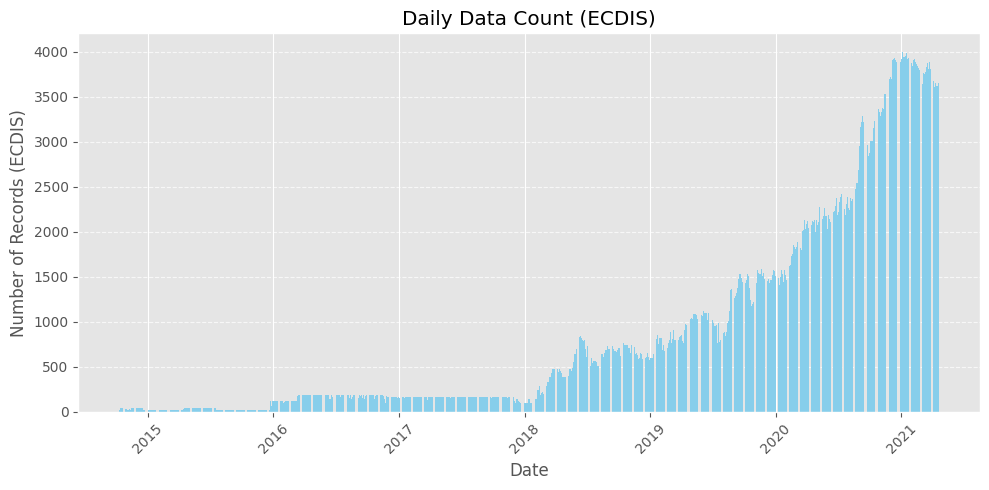

In [113]:
# 日付ごとの行数をカウント
daily_counts_ECDIS = (
    data_ECDIS_check
    .groupby("measurement_date")
    .size()
    .reset_index(name="count_ECDIS")
    .sort_values("measurement_date")
)

# 結果確認
print(daily_counts_ECDIS.head())

# 棒グラフで可視化
plt.figure(figsize=(10, 5))
plt.bar(daily_counts_ECDIS["measurement_date"], daily_counts_ECDIS["count_ECDIS"], color="skyblue")
plt.xlabel("Date")
plt.ylabel("Number of Records (ECDIS)")
plt.title("Daily Data Count (ECDIS)")
plt.xticks(rotation=45)  # 日付ラベルを斜めにして見やすく
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

  measurement_date  count_Radar
0       2016-11-04            1
1       2017-12-07            2
2       2017-12-08            2
3       2017-12-09            2
4       2017-12-11            4


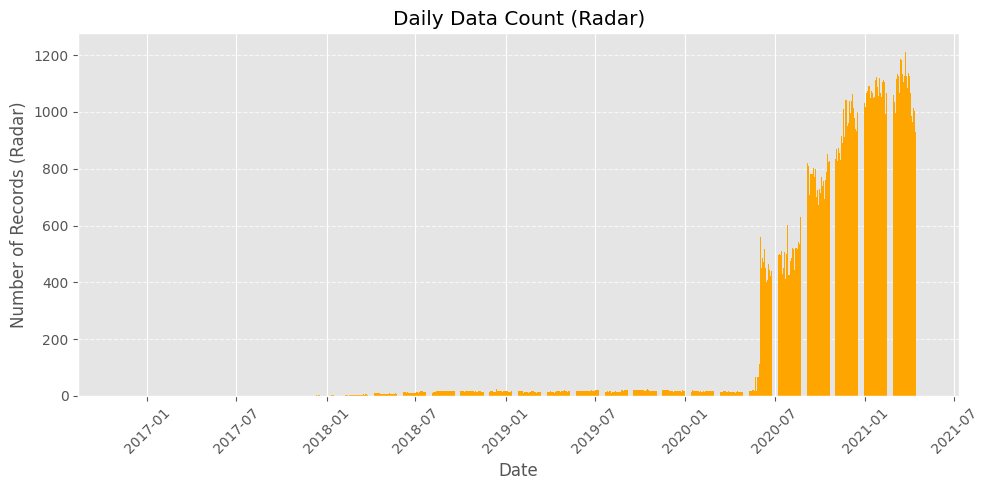

In [112]:
# 日付ごとの行数を集計
daily_counts_Radar = (
    data_Radar_check
    .groupby("measurement_date")
    .size()
    .reset_index(name="count_Radar")
    .sort_values("measurement_date")
)

# 結果確認
print(daily_counts_Radar.head())

# 棒グラフで可視化
plt.figure(figsize=(10, 5))
plt.bar(daily_counts_Radar["measurement_date"], daily_counts_Radar["count_Radar"], color="orange")
plt.xlabel("Date")
plt.ylabel("Number of Records (Radar)")
plt.title("Daily Data Count (Radar)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

調査２：対象のインスタンスを抽出する

In [114]:
data_ECDIS_ADP555 = data_ECDIS[((data_ECDIS["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3])
                          .isin(["16","15","14","13"]))]
data_Radar_ADP555 = data_Radar[((data_Radar["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3])
                          .isin(["16","15","14","13"]))]

In [115]:
data_Radar_ADP555.head()

id equipment_label_no f_shipno     measurement_date  \
19819  9778129-537                537  9778129  2018-05-28 07:19:57   
19820  9778129-537                537  9778129  2018-05-29 07:19:56   
19821  9778129-537                537  9778129  2018-05-30 07:19:56   
19822  9778129-537                537  9778129  2018-05-31 07:19:55   
19823  9778129-537                537  9778129  2018-06-01 07:19:55   

      processor_unit_units_hardware_info_serial_number_cpu_bd  \
19819                                           O15J8580        
19820                                           O15J8580        
19821                                           O15J8580        
19822                                           O15J8580        
19823                                           O15J8580        

      monitor1_units_unit  monitor2_units_unit measurement_ymd  \
19819              MU-231                  NaN      2018-05-28   
19820              MU-231                  NaN      2018-05-29   
19821              MU-231                  NaN      2018-05-30   
19822              MU-231                  NaN      2018-05-31   
19823              MU-231                  NaN      2018-06-01   

      measurement_ymd_h  measurement_ymd_hms  ...  \
19819                07  2018-05-28 07:00:00  ...   
19820                07  2018-05-29 07:00:00  ...   
19821                07  2018-05-30 07:00:00  ...   
19822                07  2018-05-31 07:00:00  ...   
19823                07  2018-06-01 07:00:00  ...   

       processor_unit_units_status_cpu_board_remote1_temp  \
19819                                               46.0    
19820                                               49.0    
19821                                               46.0    
19822                                               47.0    
19823                                               45.0    

       processor_unit_units_status_cpu_board_remote2_temp  \
19819                                               42.0    
19820                                               45.0    
19821                                               42.0    
19822                                               43.0    
19823                                               41.0    

       processor_unit_units_status_cpu_board_cpu_core_vol  \
19819                                              1.078    
19820                                              1.113    
19821                                              1.031    
19822                                              0.914    
19823                                              1.125    

       processor_unit_units_status_cpu_board_cpu_bd_vbat  \
19819                                              3.698   
19820                                              3.698   
19821                                              3.698   
19822                                              3.698   
19823                                              3.698   

       processor_unit_units_status_cpu_board_cpu_bd_p3_3v  \
19819                                              3.403    
19820                                              3.403    
19821                                              3.403    
19822                                              3.403    
19823                                              3.403    

       processor_unit_units_status_cpu_board_cpu_bd_p5v  \
19819                                             5.156   
19820                                             5.156   
19821                                             5.156   
19822                                             5.156   
19823                                             5.156   

       processor_unit_units_status_cpu_board_cpu_bd_p12v  \
19819                                               12.0   
19820                                               12.0   
19821                                               12.0   
19822                                               12.0  

In [116]:
Select_id_data_set_ECDIS=data_ECDIS_ADP555[data_ECDIS_ADP555["id"]=="9748019T-325"]
Select_id_data_set_Radar=data_Radar_ADP555[data_Radar_ADP555["id"]=="9748019T-325"]

In [117]:
len(Select_id_data_set_ECDIS)

26591

In [118]:
len(Select_id_data_set_Radar)

0

必要な列のみを抽出する

In [119]:
colums_list=["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v","measurement_date"]

In [127]:
data_ECDIS_check = Select_id_data_set_ECDIS[colums_list]
data_Radar_check = Select_id_data_set_Radar[colums_list]

In [121]:
data_ECDIS_check.head()

processor_unit_units_status_cpu_board_cpu_fan  \
1038151                                         5850.0   
1038152                                         5844.0   
1038153                                         5844.0   
1038154                                         5850.0   
1038155                                         5856.0   

         processor_unit_units_status_cpu_board_cpu_bd_fan1  \
1038151                                             4595.0   
1038152                                             4599.0   
1038153                                             4599.0   
1038154                                             4611.0   
1038155                                             4599.0   

         processor_unit_units_status_cpu_board_cpu_bd_fan2  \
1038151                                             4745.0   
1038152                                             4724.0   
1038153                                             4736.0   
1038154                                             4736.0   
1038155                                             4753.0   

         processor_unit_units_status_cpu_board_cpu_bd_temp  \
1038151                                               49.0   
1038152                                               47.0   
1038153                                               47.0   
1038154                                               48.0   
1038155                                               49.0   

         processor_unit_units_status_cpu_board_cpu_core_temp  \
1038151                                               61.0     
1038152                                               59.0     
1038153                                               59.0     
1038154                                               60.0     
1038155                                               61.0     

         processor_unit_units_status_cpu_board_gpu_core_temp  \
1038151                                               58.0     
1038152                                               56.0     
1038153                                               56.0     
1038154                                               57.0     
1038155                                               58.0     

         processor_unit_units_status_cpu_board_cpu_core_vol  \
1038151                                              1.125    
1038152                                              0.911    
1038153                                              1.066    
1038154                                              1.140    
1038155                                              1.102    

         processor_unit_units_status_cpu_board_cpu_bd_vbat  \
1038151                                              3.704   
1038152                                              3.711   
1038153                                              3.711   
1038154                                              3.704   
1038155                                              3.704   

         processor_unit_units_status_cpu_board_cpu_bd_p3_3v  \
1038151                                              3.420    
1038152                                              3.420    
1038153                                              3.420    
1038154                                              3.420    
1038155                                              3.424    

         processor_unit_units_status_cpu_board_cpu_bd_p5v  \
1038151                                              5.12   
1038152                                              5.12   
1038153                                              5.12   
1038154                                              5.12   
1038155                                              5.12   

         processor_unit_units_status_cpu_board_cpu_bd_p12v  \
1038151                                             11.874   
1038152                                             11.874   
1038153                                             11.874   
1038154                  

In [132]:
# measurement_date を datetime 型に変換（※時刻情報を保持）
data_ECDIS_check["measurement_date"] = pd.to_datetime(
    data_ECDIS_check["measurement_date"], errors="coerce"
)

# 各時間に丸めて集計
data_ECDIS_check["measurement_hour"] = data_ECDIS_check["measurement_date"].dt.floor("H")

# 時間ごとの行数をカウント
hourly_counts_ECDIS = (
    data_ECDIS_check
    .groupby("measurement_hour")
    .size()
    .reset_index(name="count_ECDIS")
    .sort_values("measurement_hour")
)

# 結果確認
print(hourly_counts_ECDIS.head())

     measurement_hour  count_ECDIS
0 2015-12-21 06:00:00            1
1 2015-12-22 06:00:00            2
2 2015-12-22 07:00:00            1
3 2015-12-22 08:00:00            1
4 2015-12-22 09:00:00            1


C:\Users\keisu\AppData\Local\Temp\ipykernel_18436\976435104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ECDIS_check["measurement_date"] = pd.to_datetime(
C:\Users\keisu\AppData\Local\Temp\ipykernel_18436\976435104.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ECDIS_check["measurement_hour"] = data_ECDIS_check["measurement_date"].dt.floor("H")
C:\Users\keisu\AppData\Local\Temp\ipykernel_18436\976435104.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

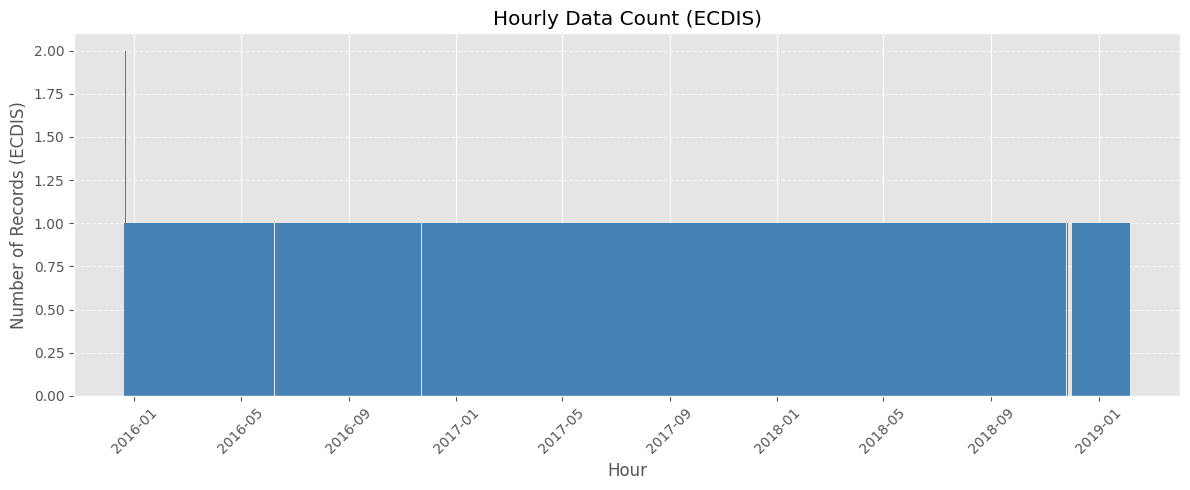

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(hourly_counts_ECDIS["measurement_hour"], hourly_counts_ECDIS["count_ECDIS"], color="steelblue")
plt.xlabel("Hour")
plt.ylabel("Number of Records (ECDIS)")
plt.title("Hourly Data Count (ECDIS)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [137]:
# 一時間あたりの取得件数が2件以上の行を抽出
high_activity_hours_ECDIS = hourly_counts_ECDIS[hourly_counts_ECDIS["count_ECDIS"] >= 2]

# 結果確認
print("一時間に2件以上取得している日付一覧:")
print(high_activity_days_ECDIS)


一時間に2件以上取得している日付一覧:
1    2015-12-22
Name: measurement_hour, dtype: object


In [138]:
# 念のため measurement_date を datetime に変換し、日付部分のみ取得
data_ECDIS_check["measurement_date"] = pd.to_datetime(
    data_ECDIS_check["measurement_date"], errors="coerce"
).dt.date

# 日付ごとの行数をカウント
daily_counts_ECDIS = (
    data_ECDIS_check
    .groupby("measurement_date")
    .size()
    .reset_index(name="count_ECDIS")
    .sort_values("measurement_date")
)

# 結果確認
print(daily_counts_ECDIS.head())

  measurement_date  count_ECDIS
0       2015-12-21            1
1       2015-12-22           19
2       2015-12-23           24
3       2015-12-24           24
4       2015-12-25           24


C:\Users\keisu\AppData\Local\Temp\ipykernel_18436\3009621909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ECDIS_check["measurement_date"] = pd.to_datetime(


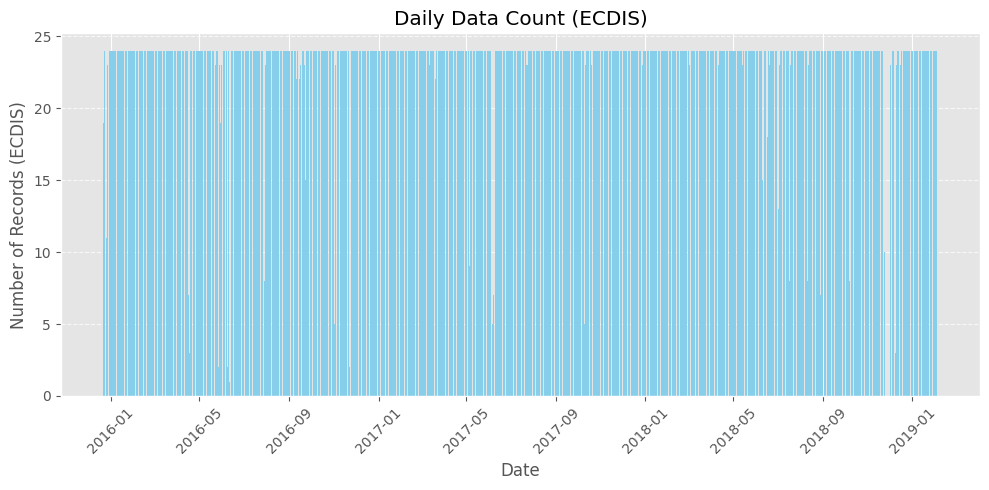

In [140]:
plt.figure(figsize=(10, 5))
plt.bar(
    daily_counts_ECDIS["measurement_date"],  # x軸：日付
    daily_counts_ECDIS["count_ECDIS"],       # y軸：件数
    color="skyblue"
)

plt.xlabel("Date")
plt.ylabel("Number of Records (ECDIS)")
plt.title("Daily Data Count (ECDIS)")
plt.xticks(rotation=45)  # 日付ラベルを斜め表示で見やすく
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [142]:
# 一日あたりの取得件数が15件以下の行を抽出
daily_counts_ECDIS = daily_counts_ECDIS[daily_counts_ECDIS["count_ECDIS"] <= 15]

# 結果確認
print("一日あたりの取得件数が15件以下の日付一覧:")
print(daily_counts_ECDIS)

一日あたりの取得件数が15件以下の日付一覧:
     measurement_date  count_ECDIS
0          2015-12-21            1
5          2015-12-26           11
117        2016-04-16            7
118        2016-04-17            3
158        2016-05-27            2
170        2016-06-08            2
173        2016-06-11            1
221        2016-07-29            8
268        2016-09-14            5
277        2016-09-23           15
317        2016-11-02            5
337        2016-11-22            2
501        2017-05-05            9
533        2017-06-06            5
534        2017-06-07            7
658        2017-10-10            5
873        2018-05-13            9
901        2018-06-10           15
910        2018-06-19            9
921        2018-06-30            2
923        2018-07-02           13
938        2018-07-17            8
963        2018-08-11            8
980        2018-08-28            7
1020       2018-10-07            8
1061       2018-11-18            1
1067       2018-11-24           

In [63]:
data_Radar_check.head()

Empty DataFrame
Columns: [processor_unit_units_status_cpu_board_cpu_fan, processor_unit_units_status_cpu_board_cpu_bd_fan1, processor_unit_units_status_cpu_board_cpu_bd_fan2, processor_unit_units_status_cpu_board_cpu_bd_temp, processor_unit_units_status_cpu_board_cpu_core_temp, processor_unit_units_status_cpu_board_gpu_core_temp, processor_unit_units_status_cpu_board_cpu_core_vol, processor_unit_units_status_cpu_board_cpu_bd_vbat, processor_unit_units_status_cpu_board_cpu_bd_p3_3v, processor_unit_units_status_cpu_board_cpu_bd_p5v, processor_unit_units_status_cpu_board_cpu_bd_p12v, measurement_date]
Index: []

データの結合を行う

In [12]:
con=pd.concat([data_Radar, data_ECDIS])
data_con=con

キャッシュの削除

In [13]:
del raw_data_ECDIS
del raw_data_Radar

In [14]:
gc.collect()

0

データの確認

In [15]:
print("ECDIS&Radar")
print("f_shipnoユニーク数          :",data_con["f_shipno"].nunique())
print("equipment_label_noユニーク数:",len(data_con["equipment_label_no"].unique()),"\n")

print("ECDIS")
print("f_shipnoユニーク数          :",data_ECDIS["f_shipno"].nunique())
print("equipment_label_noユニーク数:",len(data_ECDIS["equipment_label_no"].unique()),"\n")

print("Radar")
print("f_shipnoユニーク数          :",data_Radar["f_shipno"].nunique())
print("equipment_label_noユニーク数:",len(data_Radar["equipment_label_no"].unique()),"\n")

ECDIS&Radar
f_shipnoユニーク数          : 114
equipment_label_noユニーク数: 367 

ECDIS
f_shipnoユニーク数          : 112
equipment_label_noユニーク数: 271 

Radar
f_shipnoユニーク数          : 46
equipment_label_noユニーク数: 96 



In [16]:
# raw_data.shape
print("行数: "+str(data_con.shape[0]))
print("列数: "+str(data_con.shape[1]))
#データ期間
print("データ開始日時: "+str(data_con["measurement_date"].min()))
print("データ終了日時: "+str(data_con["measurement_date"].max()))
print("f_shipno(ユニーク数): "+str(data_con["f_shipno"].nunique()))
print("equipment_label_no(ユニーク数): "+str(data_con["equipment_label_no"].nunique()))

行数: 2339341
列数: 33
データ開始日時: 2014-10-10 09:00:01
データ終了日時: 2021-04-20 23:34:16
f_shipno(ユニーク数): 114
equipment_label_no(ユニーク数): 367


フォーマットの変更

In [17]:
data_con["measurement_ymd_hms"] = pd.to_datetime(data_con["measurement_ymd_hms"], format='%Y-%m-%d %H:%M:%S')
data_con.describe()

measurement_ymd_hms  monitor1_units_status_main_temp  \
count                        2339341                     2.316819e+06   
mean   2020-02-29 14:19:01.995460352                     4.169940e+01   
min              2014-10-10 09:00:00                    -2.100000e+01   
25%              2019-09-19 21:00:00                     3.800000e+01   
50%              2020-07-26 08:00:00                     4.200000e+01   
75%              2020-12-22 11:00:00                     4.500000e+01   
max              2021-04-20 23:00:00                     7.200000e+01   
std                              NaN                     4.601056e+00   

       monitor1_units_status_main_fan1  monitor1_units_status_main_fan2  \
count                     2.130016e+06                     2.074404e+06   
mean                      3.690696e+03                     3.484889e+03   
min                       0.000000e+00                     2.742000e+03   
25%                       2.985000e+03                     2.985000e+03   
50%                       3.073000e+03                     3.073000e+03   
75%                       5.209000e+03                     4.595000e+03   
max                       5.542000e+03                     4.811000e+03   
std                       1.041321e+03                     7.338120e+02   

       monitor1_units_status_main_fan3  monitor2_units_status_main_temp  \
count                     2.074404e+06                     60167.000000   
mean                      3.397851e+03                        40.137035   
min                       2.657000e+03                       -20.000000   
25%                       2.868000e+03                        38.000000   
50%                       2.956000e+03                        40.000000   
75%                       4.595000e+03                        43.000000   
max                       4.841000e+03                        54.000000   
std                       7.798650e+02                         4.088452   

       monitor2_units_status_main_fan1  monitor2_units_status_main_fan2  \
count                     28627.000000                     15343.000000   
mean                       4139.440004                      2977.105195   
min                        2868.000000                      2839.000000   
25%                        3043.000000                      2956.000000   
50%                        3102.000000                      2985.000000   
75%                        5424.000000                      2985.000000   
max                        5555.000000                      3051.000000   
std                        1207.438474                        24.402830   

       monitor2_units_status_main_fan3  \
count                     15343.000000   
mean                       2920.743727   
min                        2809.000000   
25%                        2868.000000   
50%                        2956.000000   
75%                        2956.000000   
max                        3014.000000   
std                          56.522768   

       processor_unit_units_status_cpu_board_cpu_fan  ...  \
count                                   2.339011e+06  ...   
mean                                    5.911445e+03  ...   
min                                    -1.000000e+00  ...   
25%                                     5.825000e+03  ...   
50%                                     5.914000e+03  ...   
75%                                     5.986000e+03  ...   
max                                     6.323000e+03  ...   
std                                     1.187962e+02  ...   

       processor_unit_units_status_cpu_board_remote1_temp  \
count                                       2.339012e+06    
mean                                        4.151572e+01    
min                                         1.300000e+01    
25%                                         3.900000e+01    
50%                                         4.100000e+01    
75%                                 

ここでデータのカラム値は以下の通りである。
カラム名	説明

id	                                                船舶番号 (f_shipno) と装置ラベル番号 (equipment_label_no) を結合したもの（ユニークID）

equipment_label_no	                                装置ラベル番号

f_shipno	                                        船舶番号

measurement_date	                                測定日時

processor_unit_units_hardware_info_serial_number_cpu_bd	CPUボードのシリアル番号

monitor1_units_unit	                                モニター1のユニット情報

monitor2_units_unit	                                モニター2のユニット情報

measurement_ymd	                                    測定日の年月日部分（YYYY-MM-DD）

measurement_ymd_h	                                測定日の時間部分（HH）

measurement_ymd_hms	                                測定日の詳細な日時（YYYY-MM-DD HH:00:00）

monitor1_units_status_main_temp	                    モニター1のメインステータスの温度

monitor1_units_status_main_fan1	                    モニター1のメインステータスのファン1

monitor1_units_status_main_fan2	                    モニター1のメインステータスのファン2

monitor1_units_status_main_fan3	                    モニター1のメインステータスのファン3

monitor2_units_status_main_temp	                    モニター2のメインステータスの温度

monitor2_units_status_main_fan1	                    モニター2のメインステータスのファン1

monitor2_units_status_main_fan2	                    モニター2のメインステータスのファン2

monitor2_units_status_main_fan3	                    モニター2のメインステータスのファン3

processor_unit_units_status_cpu_board_cpu_fan	    CPUボードのCPUファンステータス

processor_unit_units_status_cpu_board_cpu_bd_temp	CPUボードの温度

processor_unit_units_status_cpu_board_cpu_core_temp	CPUコアの温度

processor_unit_units_status_cpu_board_gpu_core_temp	GPUコアの温度

processor_unit_units_status_cpu_board_remote1_temp	リモート1の温度

processor_unit_units_status_cpu_board_remote2_temp	リモート2の温度

processor_unit_units_status_cpu_board_cpu_core_vol	CPUコアの電圧

processor_unit_units_status_cpu_board_cpu_bd_vbat	CPUボードのバッテリ電圧

processor_unit_units_status_cpu_board_cpu_bd_p3_3v	CPUボードの3.3V電源

processor_unit_units_status_cpu_board_cpu_bd_p5v	CPUボードの5V電源

processor_unit_units_status_cpu_board_cpu_bd_p12v	CPUボードの12V電源

processor_unit_units_status_cpu_board_cpu_bd_fan1	CPUボードのファン1

processor_unit_units_status_cpu_board_cpu_bd_fan2	CPUボードのファン2

processor_unit_units_status_boot_device_wearout_ind	起動デバイスの摩耗インデックス

以下、データの加工を行う。なお取り出す条件は

・一時間に複数のデータを取得した場合は最初に取得したデータのみを使用する

・そのうえで一日に取得したデータの合計が15件に満たない場合はその日のデータは使用しない

最初に取得したデータのみを使用する

ロジックはid、日、時間でグループ分けを行って最も時間が上のものを取り出す。

In [18]:
# 1時間に1データに変更
data_con["measurement_date"] = pd.to_datetime(data_con["measurement_date"], format='%Y-%m-%d %H:%M:%S')

data_con["order"] = data_con.groupby(["id", "measurement_ymd", "measurement_ymd_h"])["measurement_date"].rank()

modified_data = data_con[data_con["order"]==1]

取得したデータが15件に満たない場合はその日のデータは使用しない

ロジックは、idｔ日にちでグループ分けしてそのユニーク値を数ええる。さらにその中で最も若い日付と古い日付を算出する。

In [19]:
check_day_cnt = modified_data.groupby(["id", "measurement_ymd"]).agg({"measurement_date":"nunique"}).assign(
    min_measurement_date = modified_data.groupby(['id', "measurement_ymd"]).agg({"measurement_date":"min"}),
    max_measurement_date = modified_data.groupby(['id', "measurement_ymd"]).agg({"measurement_date":"max"})).reset_index()

check_day_cnt["id_date"] = check_day_cnt["id"]+"-"+check_day_cnt["measurement_ymd"]

check_day_cnt = check_day_cnt.rename(columns={"measurement_date":"cnt"})

check_day_cnt.head(5)

id measurement_ymd  cnt min_measurement_date max_measurement_date  \
0  9531868-309      2014-10-10   15  2014-10-10 09:00:01  2014-10-10 23:00:01   
1  9531868-309      2014-10-11   24  2014-10-11 00:00:02  2014-10-11 23:00:01   
2  9531868-309      2014-10-12   24  2014-10-12 00:00:01  2014-10-12 23:00:01   
3  9531868-309      2014-10-13   24  2014-10-13 00:00:01  2014-10-13 23:00:02   
4  9531868-309      2014-10-14   24  2014-10-14 00:00:02  2014-10-14 23:00:02   

                  id_date  
0  9531868-309-2014-10-10  
1  9531868-309-2014-10-11  
2  9531868-309-2014-10-12  
3  9531868-309-2014-10-13  
4  9531868-309-2014-10-14

さらに作成したcntの中で15件以上のものを抜き出す。

In [39]:
target_id_date = check_day_cnt[check_day_cnt["cnt"] >= 15]["id_date"]

条件１を施したデータに対して準備を行う

In [21]:
modified_data["tag"] = modified_data["id"]+"-"+modified_data["measurement_ymd"]
# modified_data.head()

C:\Users\小山佳祐\AppData\Local\Temp\ipykernel_7640\1843079938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_data["tag"] = modified_data["id"]+"-"+modified_data["measurement_ymd"]


条件１のデータのうち条件２にも当てはまるものを抜き出す

In [22]:
final_data = modified_data[modified_data["tag"].isin(target_id_date)]
final_data.shape

(2275886, 35)

以下、サブカテゴリ分けを行う。なお今回はcpuのシリアルボードナンバーでカテゴリ分けされている。

In [23]:
(final_data["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3]).unique()

array(['19', '17', '18', '16', '20', '13', '15', '14'], dtype=object)

ADP555の抜き出し

In [24]:
data_ADP556 = final_data[(final_data["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3]
                          .isin(['20','19','18','17']))]
data_ADP556[["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"
             ,"processor_unit_units_status_cpu_board_remote1_temp","processor_unit_units_status_cpu_board_remote2_temp"
             ,]].describe()

processor_unit_units_status_cpu_board_cpu_fan  \
count                                   1.731426e+06   
mean                                    5.913182e+03   
std                                     1.214072e+02   
min                                    -1.000000e+00   
25%                                     5.818000e+03   
50%                                     5.914000e+03   
75%                                     6.000000e+03   
max                                     6.323000e+03   

       processor_unit_units_status_cpu_board_cpu_bd_fan1  \
count                                       1.731426e+06   
mean                                        4.680439e+03   
std                                         9.150471e+01   
min                                        -1.000000e+00   
25%                                         4.619000e+03   
50%                                         4.687000e+03   
75%                                         4.745000e+03   
max                                         4.958000e+03   

       processor_unit_units_status_cpu_board_cpu_bd_fan2  \
count                                       1.731426e+06   
mean                                        4.801826e+03   
std                                         9.149267e+01   
min                                         3.573000e+03   
25%                                         4.741000e+03   
50%                                         4.808000e+03   
75%                                         4.869000e+03   
max                                         5.113000e+03   

       processor_unit_units_status_cpu_board_cpu_bd_temp  \
count                                       1.731426e+06   
mean                                        4.235380e+01   
std                                         3.711986e+00   
min                                         1.600000e+01   
25%                                         4.000000e+01   
50%                                         4.200000e+01   
75%                                         4.500000e+01   
max                                         6.500000e+01   

       processor_unit_units_status_cpu_board_cpu_core_temp  \
count                                       1.731426e+06     
mean                                        6.002206e+01     
std                                         4.535062e+00     
min                                         2.700000e+01     
25%                                         5.700000e+01     
50%                                         6.000000e+01     
75%                                         6.300000e+01     
max                                         8.700000e+01     

       processor_unit_units_status_cpu_board_gpu_core_temp  \
count                                       1.731426e+06     
mean                                        6.044465e+01     
std                                         4.477263e+00     
min                                         0.000000e+00     
25%                                         5.800000e+01     
50%                                         6.100000e+01     
75%                                         6.300000e+01     
max                                         2.550000e+02     

       processor_unit_units_status_cpu_board_cpu_core_vol  \
count                                       1.731426e+06    
mean                                        8.568314e-01    
std                                         2.779877e-02    
min                                         7.730000e-01    
25%                                         8.320000e-01    
50%                                         8.550000e-01    
75%                                         8.790000e-01    
max                                         9.840000e-01    

       processor_unit_units_status_cpu_board_cpu_bd_vbat  \
count                                       1.731426e+06   
mean                                        3.721660e+00   
std                            

ADP555の抜き出し

In [25]:
data_ADP555 = final_data[((final_data["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3])
                          .isin(["16","15","14","13"]))]
data_ADP555[["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"
             ,"processor_unit_units_status_cpu_board_remote1_temp","processor_unit_units_status_cpu_board_remote2_temp"]].describe()

processor_unit_units_status_cpu_board_cpu_fan  \
count                                  544447.000000   
mean                                     5913.714920   
std                                       106.123898   
min                                      5590.000000   
25%                                      5844.000000   
50%                                      5927.000000   
75%                                      5960.000000   
max                                      6199.000000   

       processor_unit_units_status_cpu_board_cpu_bd_fan1  \
count                                      544447.000000   
mean                                         4581.979879   
std                                            59.062168   
min                                          4258.000000   
25%                                          4537.000000   
50%                                          4587.000000   
75%                                          4623.000000   
max                                          4761.000000   

       processor_unit_units_status_cpu_board_cpu_bd_fan2  \
count                                      544447.000000   
mean                                         4702.023438   
std                                            71.652722   
min                                          3701.000000   
25%                                          4667.000000   
50%                                          4720.000000   
75%                                          4749.000000   
max                                          4869.000000   

       processor_unit_units_status_cpu_board_cpu_bd_temp  \
count                                      544447.000000   
mean                                           45.404254   
std                                             3.597052   
min                                            26.000000   
25%                                            43.000000   
50%                                            45.000000   
75%                                            48.000000   
max                                            63.000000   

       processor_unit_units_status_cpu_board_cpu_core_temp  \
count                                      544447.000000     
mean                                           55.476416     
std                                             4.421462     
min                                            30.000000     
25%                                            52.000000     
50%                                            55.000000     
75%                                            58.000000     
max                                            80.000000     

       processor_unit_units_status_cpu_board_gpu_core_temp  \
count                                      544447.000000     
mean                                           56.327841     
std                                             3.867715     
min                                            37.000000     
25%                                            54.000000     
50%                                            56.000000     
75%                                            59.000000     
max                                            75.000000     

       processor_unit_units_status_cpu_board_cpu_core_vol  \
count                                      544447.000000    
mean                                            0.985795    
std                                             0.081893    
min                                             0.797000    
25%                                             0.926000    
50%                                             0.996000    
75%                                             1.055000    
max                                             1.157000    

       processor_unit_units_status_cpu_board_cpu_bd_vbat  \
count                                      544447.000000   
mean                                            3.711063   
std                            

ここで抜き出されているデータは以下のとおりである。

カラム名	説明

processor_unit_units_status_cpu_board_cpu_fan	CPUボードのCPUファンのステータス

processor_unit_units_status_cpu_board_cpu_bd_fan1	CPUボードのファン1のステータス

processor_unit_units_status_cpu_board_cpu_bd_fan2	CPUボードのファン2のステータス

processor_unit_units_status_cpu_board_cpu_bd_temp	CPUボードの温度


processor_unit_units_status_cpu_board_cpu_core_temp	CPUコアの温度

processor_unit_units_status_cpu_board_gpu_core_temp	GPUコアの温度

processor_unit_units_status_cpu_board_cpu_core_vol	CPUコアの電圧

processor_unit_units_status_cpu_board_cpu_bd_vbat	CPUボードのバッテリ電圧

processor_unit_units_status_cpu_board_cpu_bd_p3_3v	CPUボードの3.3V電源

processor_unit_units_status_cpu_board_cpu_bd_p5v	CPUボードの5V電源

processor_unit_units_status_cpu_board_cpu_bd_p12v	CPUボードの12V電源

processor_unit_units_status_cpu_board_remote1_temp	リモート1の温度

processor_unit_units_status_cpu_board_remote2_temp	リモート2の温度


各カラムに対して、ヒストグラム、QQプロットを用いて正規性の確認を行う

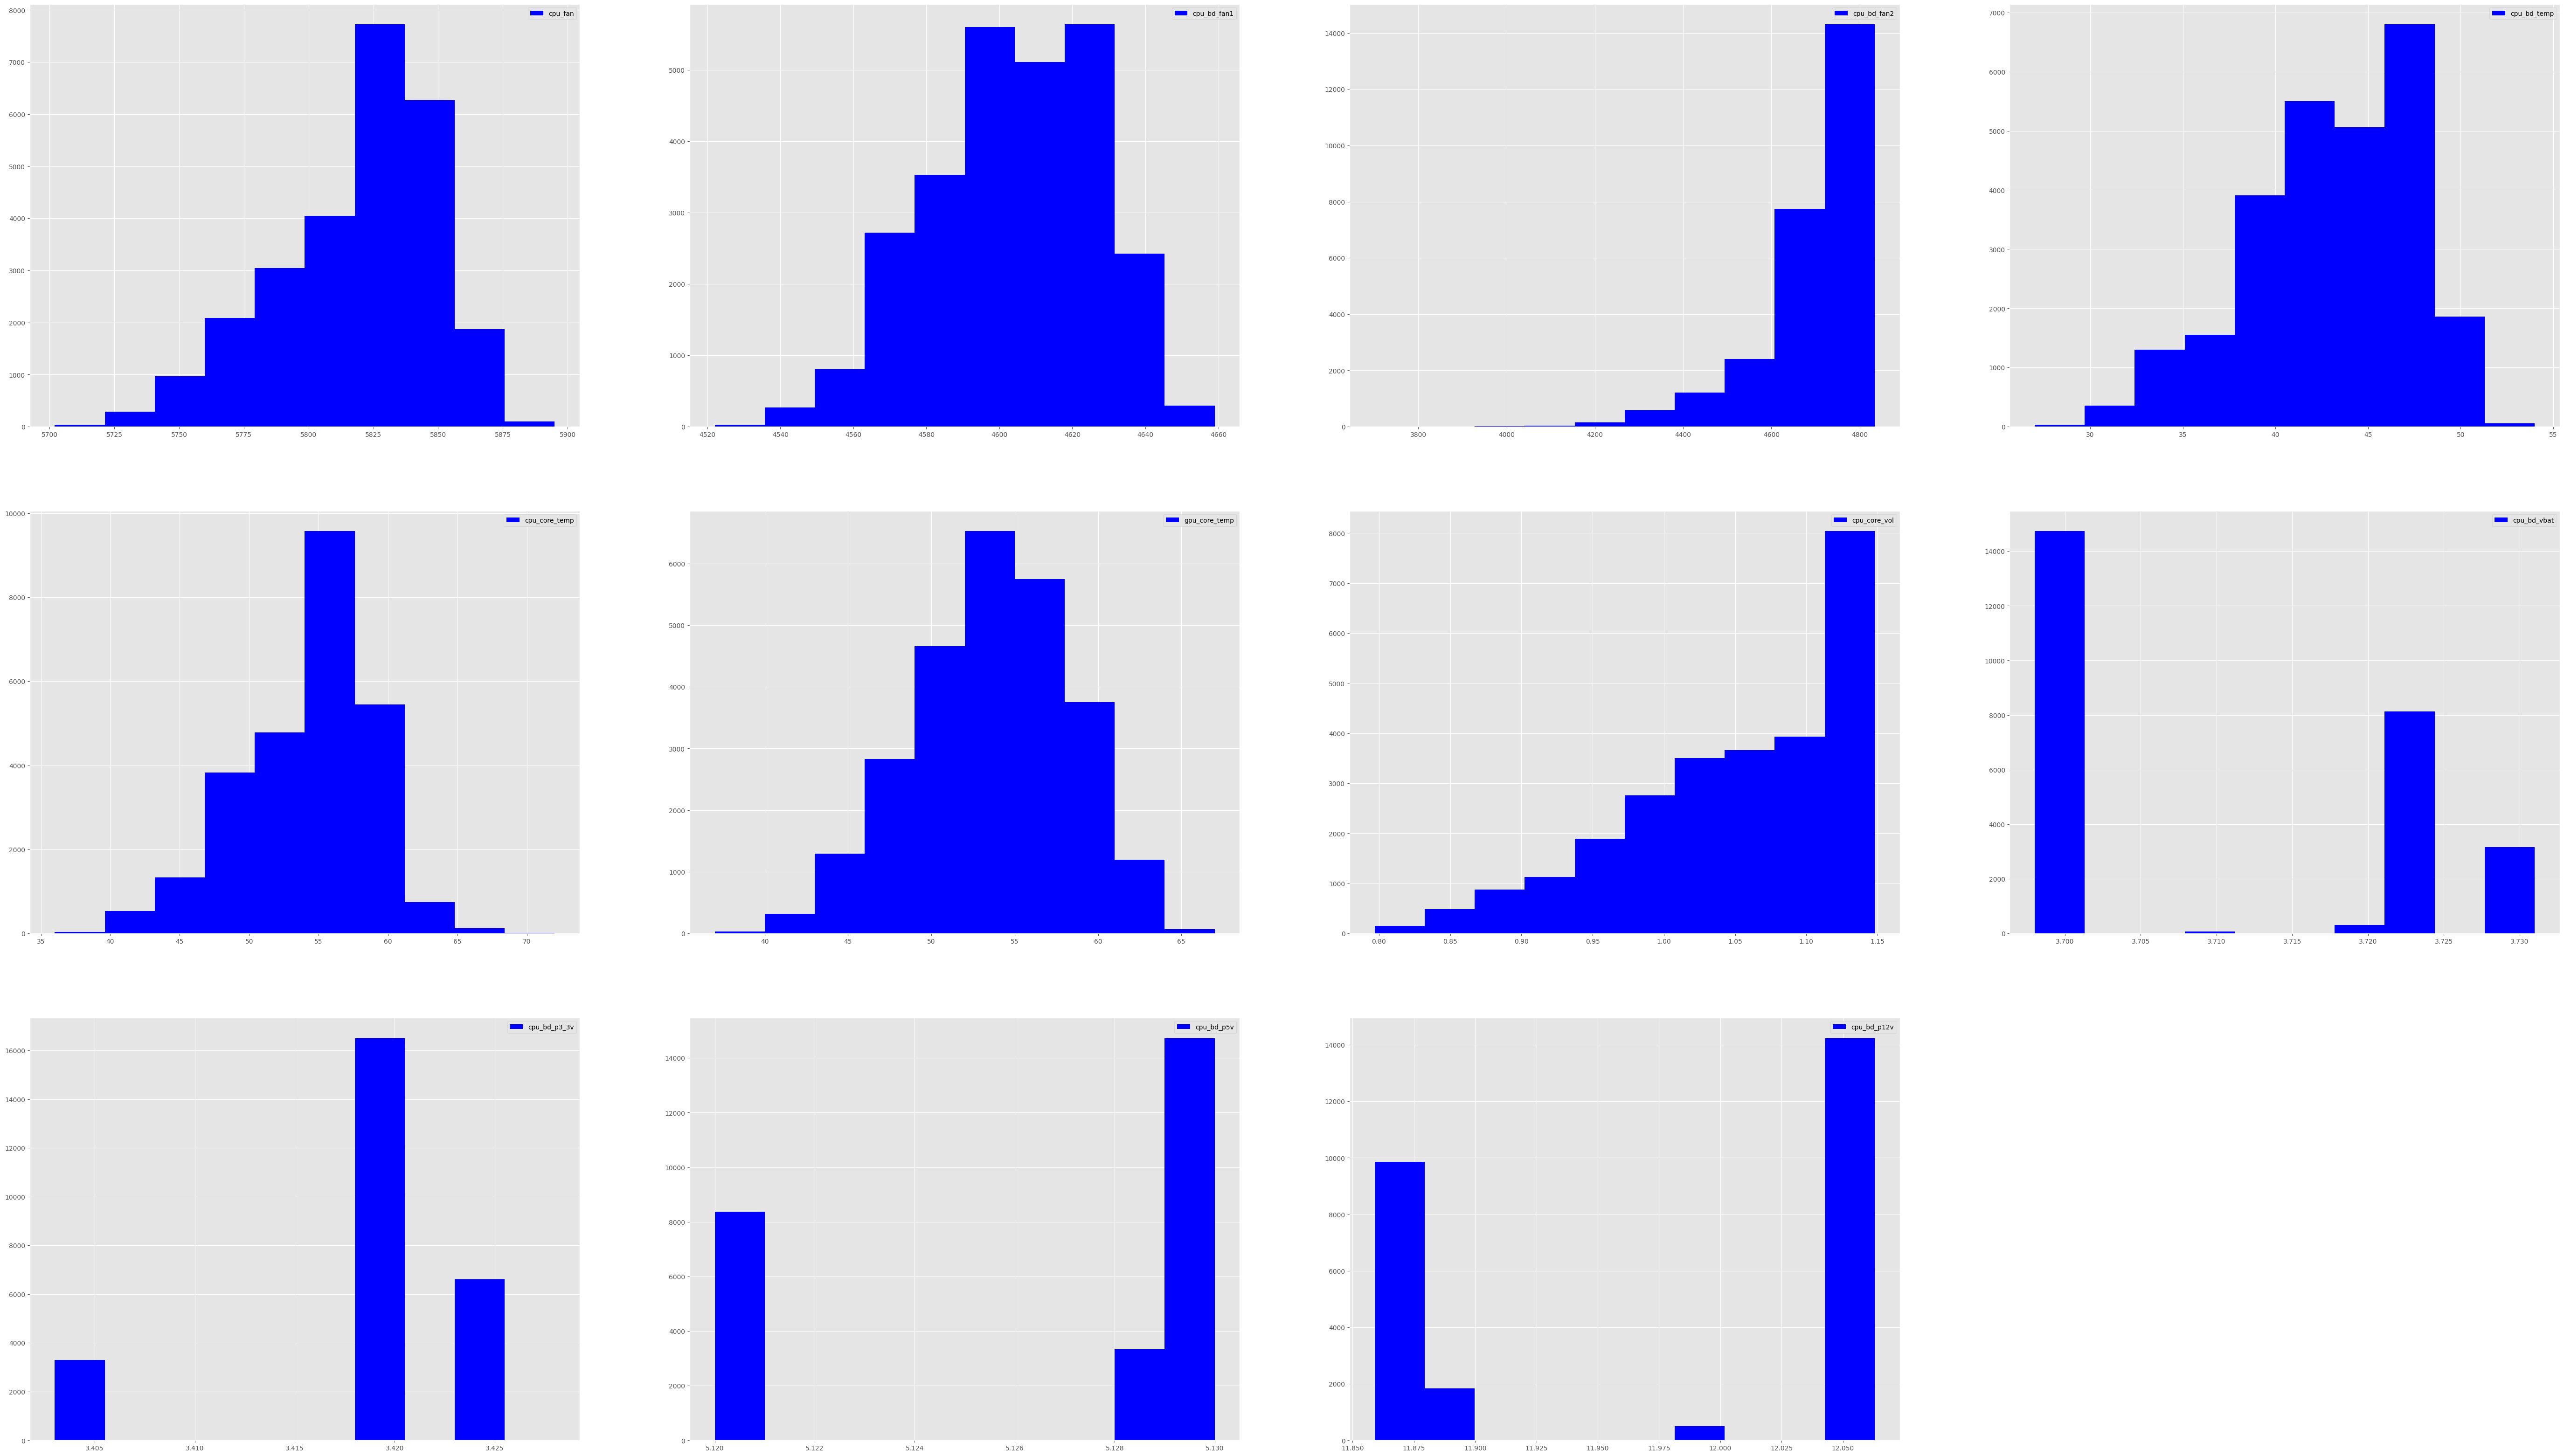

In [26]:
fig = plt.figure(figsize=(70,40))
column_list=["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"]

column_list2=["cpu_fan","cpu_bd_fan1"
             ,"cpu_bd_fan2","cpu_bd_temp"
             ,"cpu_core_temp","gpu_core_temp"
             ,"cpu_core_vol","cpu_bd_vbat"
             ,"cpu_bd_p3_3v","cpu_bd_p5v"
             ,"cpu_bd_p12v"]

check_hist=data_ADP555[data_ADP555["id"]=="9748019T-325"]

for i,label in enumerate(column_list):
    ax = fig.add_subplot(3,4,i+1)
    ax.hist(check_hist[label], color="b", label=column_list2[i] ,bins=10)
    ax.legend()

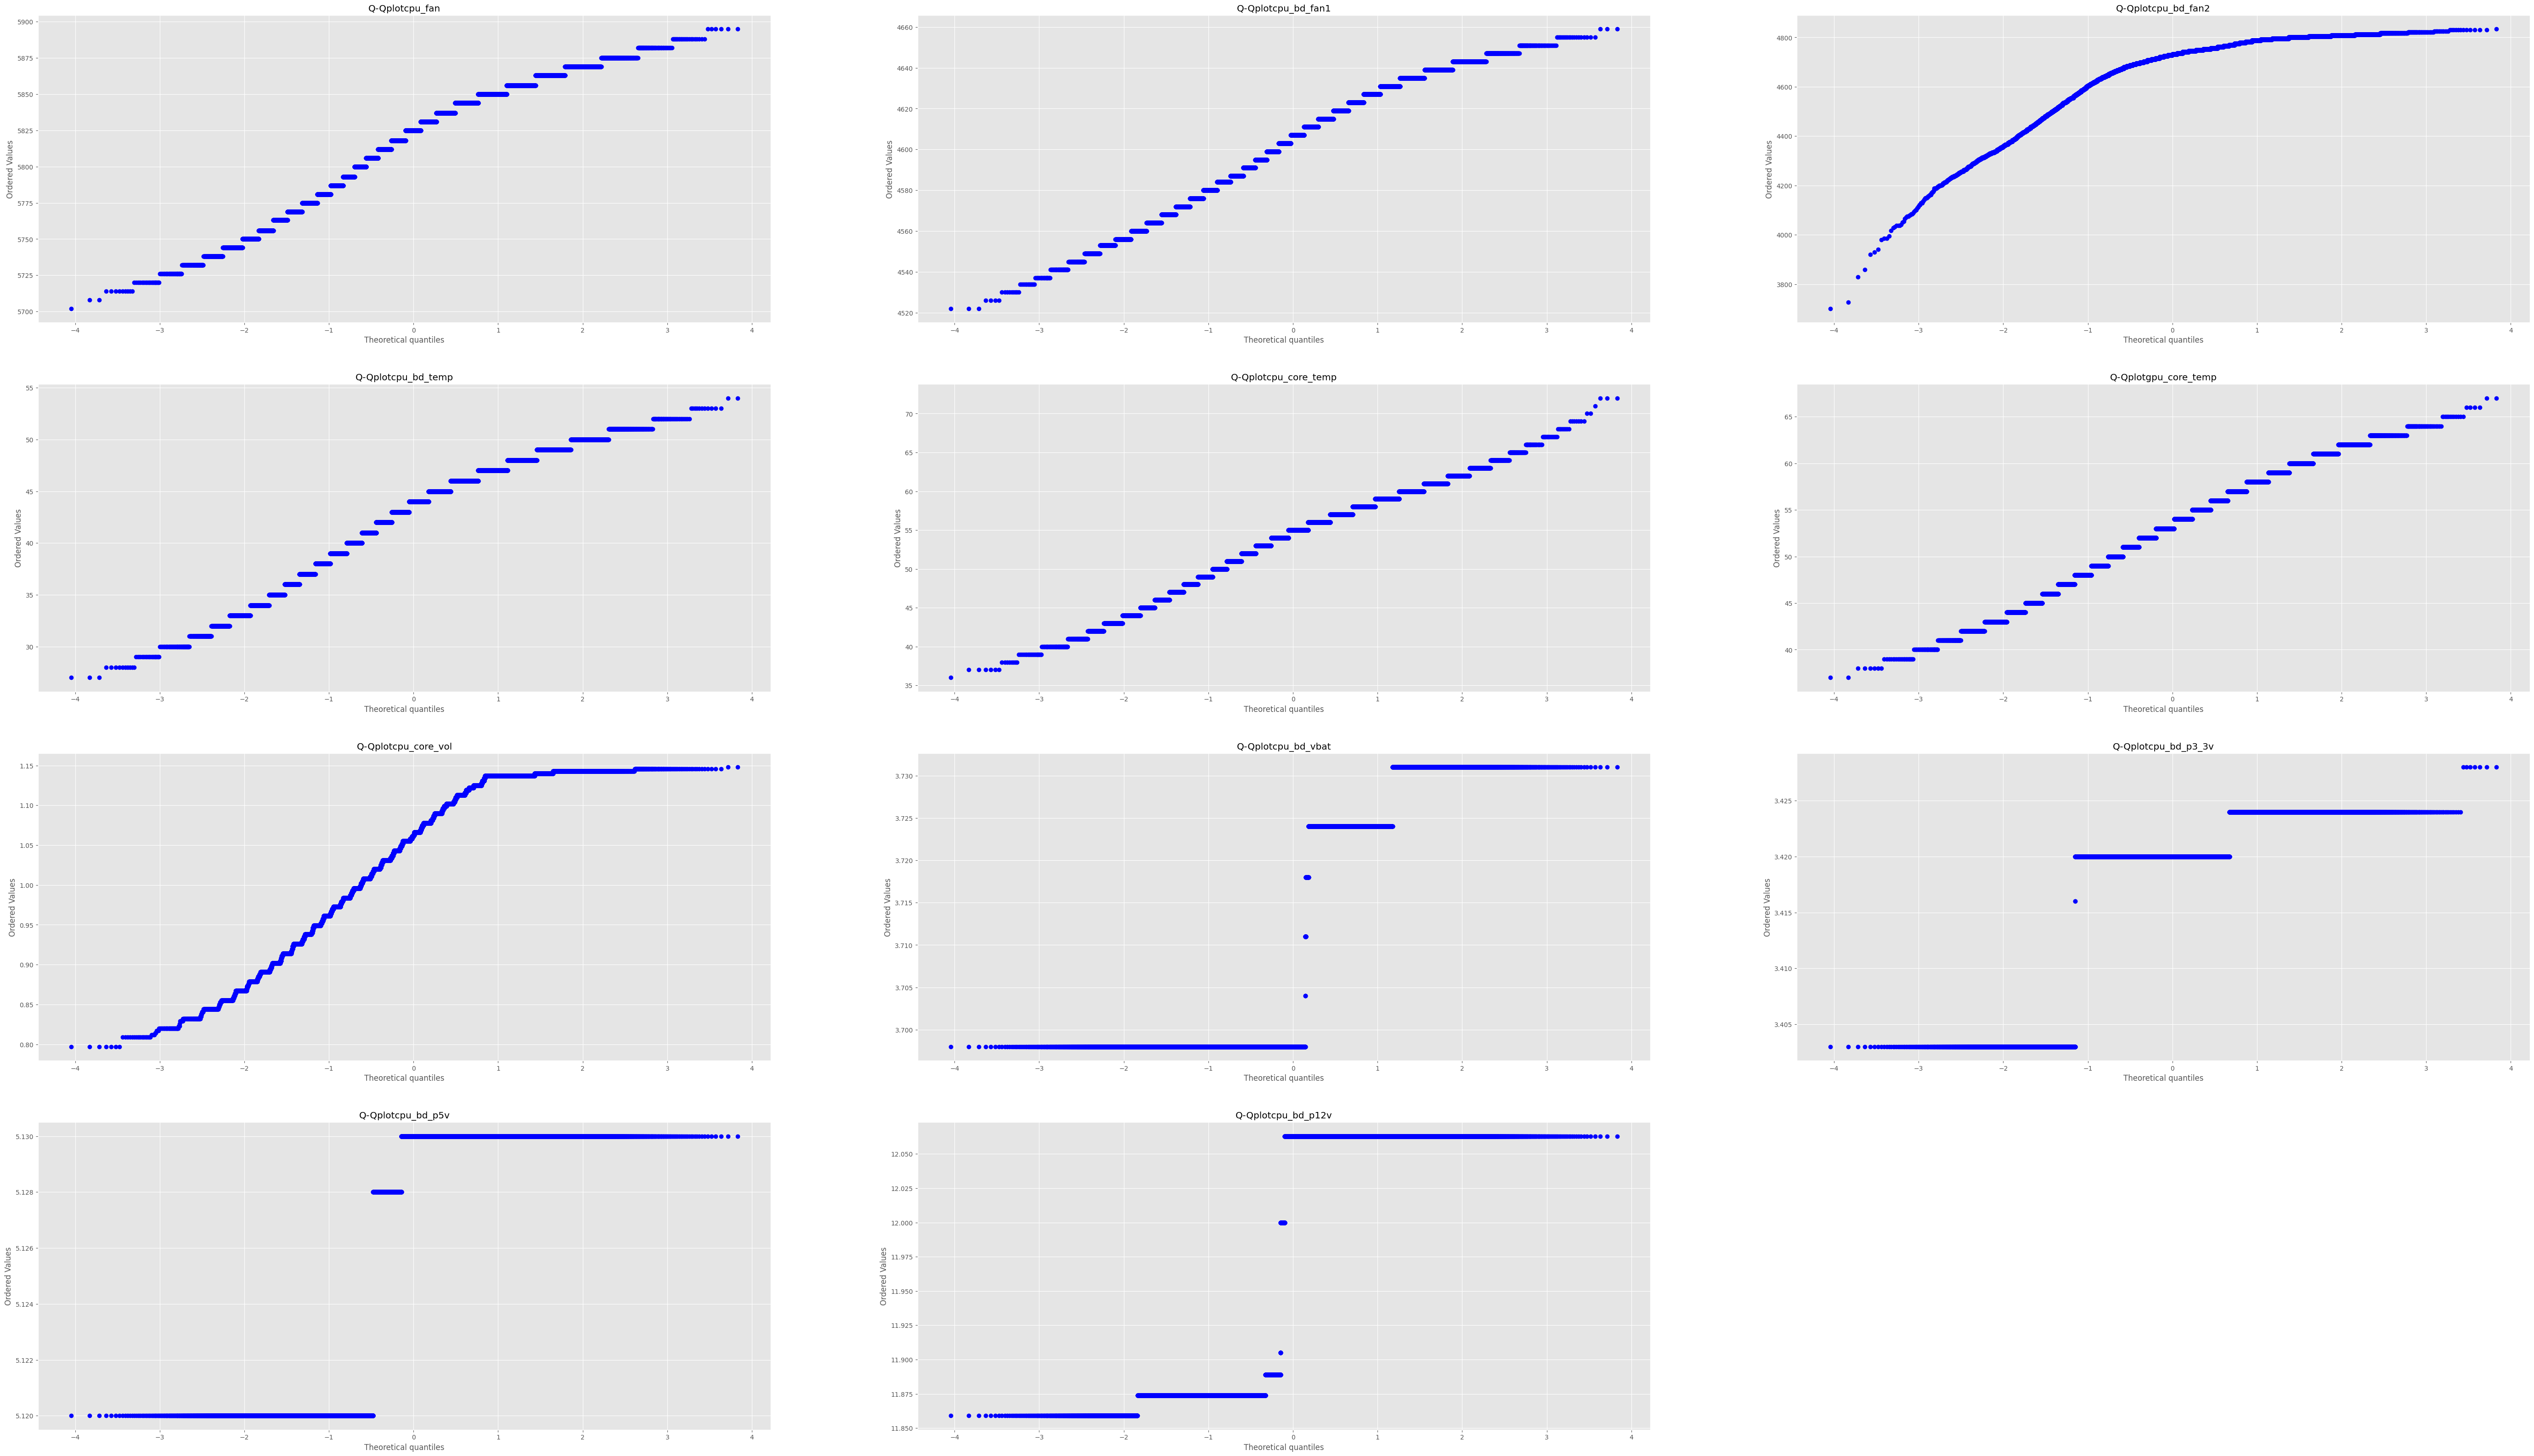

In [27]:
fig = plt.figure(figsize=(70,40))
column_list=["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"]

column_list2=["cpu_fan","cpu_bd_fan1"
             ,"cpu_bd_fan2","cpu_bd_temp"
             ,"cpu_core_temp","gpu_core_temp"
             ,"cpu_core_vol","cpu_bd_vbat"
             ,"cpu_bd_p3_3v","cpu_bd_p5v"
             ,"cpu_bd_p12v"]

check_hist=data_ADP555[data_ADP555["id"]=="9748019T-325"]

for i,label in enumerate(column_list):
    ax = fig.add_subplot(4,3,i+1)
    stats.probplot(check_hist[label], dist="norm", plot=plt)
    ax.set_title("Q-Qplot" + str(column_list2[i]))

特定の期間における processor_unit_units_status_cpu_board_cpu_bd_fan2 の値を時間軸に沿って散布図としてプロット

C:\Users\小山佳祐\AppData\Local\Temp\ipykernel_7640\1051845436.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


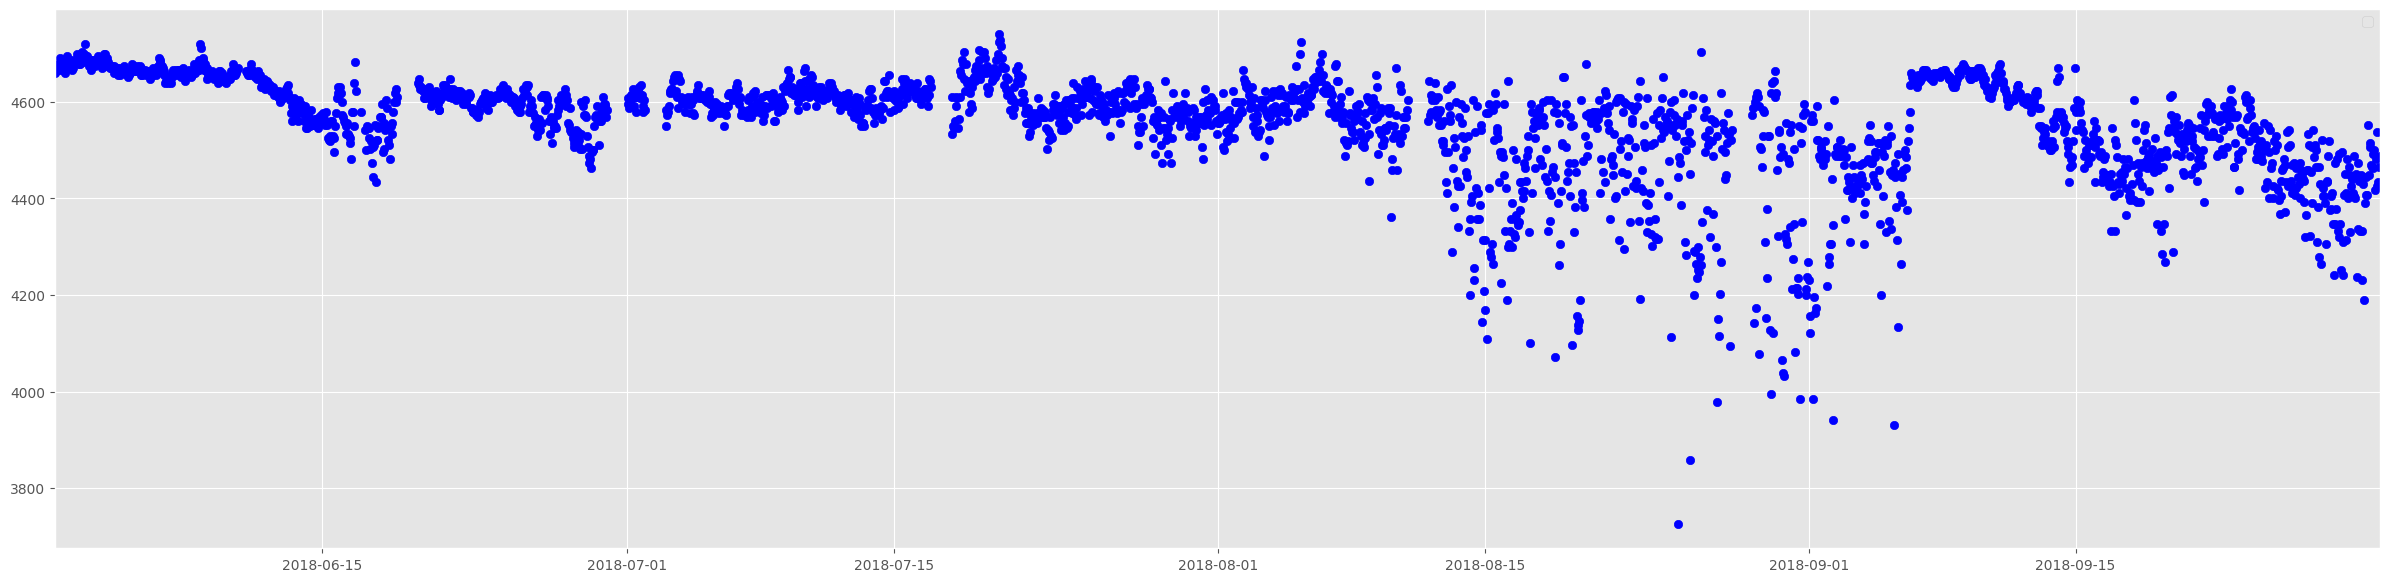

In [28]:
#期間初め
start_day=pd.to_datetime("2018/06/01 00:00:00", format='%Y/%m/%d %H:%M:%S')
#期間終わり
end_day=pd.to_datetime("2018/10/1 00:00:00", format='%Y/%m/%d %H:%M:%S')
test_select_df = check_hist[(check_hist["measurement_date"]>=start_day)&(check_hist["measurement_date"]<end_day)]

time = pd.to_datetime(test_select_df["measurement_date"], format='%Y/%m/%d %H:%M:%S')

fig = plt.figure(figsize=(30,7))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(time,test_select_df["processor_unit_units_status_cpu_board_cpu_bd_fan2"], color='blue')
ax1.set_xlim(time.min(),time.max())
ax1.legend()

ここからone class SVMの実装を行う

まずはデータセットの準備から

In [ ]:
Select_id_data_set=data_ADP555[data_ADP555["id"]=="9748019T-325"]
colums_list=["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"]

ここで使用されるカラムは

カラム名	説明

processor_unit_units_status_cpu_board_cpu_fan	CPUボードのCPUファンのステータス

processor_unit_units_status_cpu_board_cpu_bd_fan1	CPUボードのファン1のステータス

processor_unit_units_status_cpu_board_cpu_bd_fan2	CPUボードのファン2のステータス

processor_unit_units_status_cpu_board_cpu_bd_temp	CPUボードの温度

processor_unit_units_status_cpu_board_cpu_core_temp	CPUコアの温度

processor_unit_units_status_cpu_board_gpu_core_temp	GPUコアの温度

processor_unit_units_status_cpu_board_cpu_core_vol	CPUコアの電圧

processor_unit_units_status_cpu_board_cpu_bd_vbat	CPUボードのバッテリ電圧

processor_unit_units_status_cpu_board_cpu_bd_p3_3v	CPUボードの3.3V電源

processor_unit_units_status_cpu_board_cpu_bd_p5v	CPUボードの5V電源

processor_unit_units_status_cpu_board_cpu_bd_p12v	CPUボードの12V電源

In [30]:
Select_id_data_set

id equipment_label_no  f_shipno    measurement_date  \
1038152  9748019T-325                325  9748019T 2015-12-22 06:15:00   
1038154  9748019T-325                325  9748019T 2015-12-22 07:00:02   
1038155  9748019T-325                325  9748019T 2015-12-22 08:00:03   
1038156  9748019T-325                325  9748019T 2015-12-22 09:00:03   
1038157  9748019T-325                325  9748019T 2015-12-22 10:00:03   
...               ...                ...       ...                 ...   
1064736  9748019T-325                325  9748019T 2019-02-04 19:00:02   
1064737  9748019T-325                325  9748019T 2019-02-04 20:00:02   
1064738  9748019T-325                325  9748019T 2019-02-04 21:00:02   
1064739  9748019T-325                325  9748019T 2019-02-04 22:00:02   
1064740  9748019T-325                325  9748019T 2019-02-04 23:00:02   

        processor_unit_units_hardware_info_serial_number_cpu_bd  \
1038152                                           O14K5041        
1038154                                           O14K5041        
1038155                                           O14K5041        
1038156                                           O14K5041        
1038157                                           O14K5041        
...                                                    ...        
1064736                                           O14K5041        
1064737                                           O14K5041        
1064738                                           O14K5041        
1064739                                           O14K5041        
1064740                                           O14K5041        

        monitor1_units_unit monitor2_units_unit measurement_ymd  \
1038152              MU-190              MU-190      2015-12-22   
1038154              MU-190              MU-190      2015-12-22   
1038155              MU-190              MU-190      2015-12-22   
1038156              MU-190              MU-190      2015-12-22   
1038157              MU-190              MU-190      2015-12-22   
...                     ...                 ...             ...   
1064736                 NaN                 NaN      2019-02-04   
1064737                 NaN                 NaN      2019-02-04   
1064738                 NaN                 NaN      2019-02-04   
1064739                 NaN                 NaN      2019-02-04   
1064740                 NaN                 NaN      2019-02-04   

        measurement_ymd_h measurement_ymd_hms  ...  \
1038152                06 2015-12-22 06:00:00  ...   
1038154                07 2015-12-22 07:00:00  ...   
1038155                08 2015-12-22 08:00:00  ...   
1038156                09 2015-12-22 09:00:00  ...   
1038157                10 2015-12-22 10:00:00  ...   
...                   ...                 ...  ...   
1064736                19 2019-02-04 19:00:00  ...   
1064737                20 2019-02-04 20:00:00  ...   
1064738                21 2019-02-04 21:00:00  ...   
1064739                22 2019-02-04 22:00:00  ...   
1064740                23 2019-02-04 23:00:00  ...   

         processor_unit_units_status_cpu_board_cpu_bd_vbat  \
1038152                                              3.711   
1038154                                              3.704   
1038155                                              3.704   
1038156                                              3.704   
1038157                                              3.711   
...                                                    ...   
1064736                                              3.698   
1064737                                              3.698   
1064738                                              3.698   
1064739                                              3.698   
1064740                                              3.698   

         processor_unit_units_status_cpu_board_cpu_bd_p3_3v  \
1038152                                              3.420    


実験条件の整理：

1か月のデータを直近２年間のデータを使用して実験を行う

In [31]:
# measurement_dateをdatetime型に変換
Select_id_data_set["measurement_date"] = pd.to_datetime(Select_id_data_set["measurement_date"], format='%Y/%m/%d %H:%M:%S')

# measurement_dateの最小値と最大値を取得
min_date = Select_id_data_set["measurement_date"].min()
max_date = Select_id_data_set["measurement_date"].max()

# 月の差を計算
total_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month) + 1

# 結果の出力
print("Measurement Date の範囲:", min_date, "から", max_date)
print("データの月数:", total_months, "ヶ月分")


Measurement Date の範囲: 2015-12-22 06:15:00 から 2019-02-04 23:00:02
データの月数: 39 ヶ月分


C:\Users\小山佳祐\AppData\Local\Temp\ipykernel_7640\1895274812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Select_id_data_set["measurement_date"] = pd.to_datetime(Select_id_data_set["measurement_date"], format='%Y/%m/%d %H:%M:%S')


上記を見るとデータは３９か月分である。よって２年間のデータをトレーニングし、テストをするには１５回分出来る。

In [32]:
print(39-24-15)

0


モデルの準備

In [33]:
%%time
#現在時刻の取得
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

#pandasの表示オプションの設定と警告の無視
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')     

import math
import os

# 保存先
ans_data_set_no_cor=pd.DataFrame()

# パラメータ
NU=0.02
gam=1.0

# 準備
#特定のカラムの抜き出しと日時の抜き出し
data_OCSVM = Select_id_data_set[colums_list+["measurement_date"]]
data_OCSVM=data_OCSVM.dropna(how='any')
data_OCSVM=data_OCSVM.reset_index(drop = True)
data_OCSVM["measurement_date"]=pd.to_datetime(data_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')

#初期データの抜き出し
Select_data=data_OCSVM["measurement_date"][0]

#終了データの日時。トレーニングデータは２年分である。
#なお、初期データから終了データー１月までを学習データとしendデータをテストする。
data_year=Select_data.year+2
data_month=Select_data.month
end_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"


# for文の回数、モデルの学習と実行を15回繰り返す
data_len=len(data_OCSVM)
for_times=15
print("for文の回数：",for_times)
#------------------------------------------------------------------------
# スタートの傾き・モデル作成
print("-------------------------モデル1-----------------------------")

#一回目のトレーニングデータの抜き出し
model_data=data_OCSVM[data_OCSVM["measurement_date"]<end_data]
print("OCSVMトレーニング期間終了",end_data)
model_data=model_data[colums_list]
model_data=model_data.values

#データの標準化
mm_ADP555 = preprocessing.MinMaxScaler()
train_OCSVM = mm_ADP555.fit_transform((model_data).reshape(len(model_data), -1))

#０での処理のエラーを防ぐ
train_OCSVM += 0.0001

#モデルの作成
model_ADP555 = svm.OneClassSVM(nu=NU,gamma=gam,kernel="rbf")

#モデルの学習
model_ADP555.fit(train_OCSVM)

#トレーニングデータに対する予測を返す
pre_train=model_ADP555.predict(train_OCSVM)


#作成したモデルを調査する
print("設定異常割合：{:.2%}".format(NU),"\t\t学習異常割合：{:.2%}".format(len(pre_train[pre_train<0])/len(train_OCSVM)))
# print("傾き",model_ADP555.coef_)
# print("切片",model_ADP555.intercept_)
print("データ数",len(train_OCSVM))
print("サポートベクター数",len(model_ADP555.support_vectors_),"\n")

#------------------------------------------------------------------------

#テストデータに関して値を算出する
for i in range(for_times):

    #テストデータは一か月である
    start_data=end_data
    if data_month==12:
        data_month=1
        data_year+=1
    else:
        data_month+=1
    end_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"
    print("OCSVMテスト期間開始",start_data)
    print("OCSVMテスト期間終了",end_data)

    #テストデータの抜き出しを行う
    test_data=data_OCSVM[(data_OCSVM["measurement_date"]>=start_data)&(data_OCSVM["measurement_date"]<end_data)]
    data_set=test_data[["measurement_date"]+colums_list].reset_index(drop = True)
    test_data=test_data[colums_list].reset_index(drop = True)
    test_data=test_data.values
    
#------------------------------------------------------------------------
  
    #データの標準化
    test_OCSVM = mm_ADP555.transform((test_data).reshape(len(test_data), -1))
    test_OCSVM += 0.0001

    print("テストデータ数：",len(test_OCSVM))
    MinMax_data=pd.DataFrame(test_OCSVM)

    #モデルに対してテストデータを学習させ、テストデータの異常スコアを計算する。スコアが高いほど異常とする
    score_set_OCSVM=model_ADP555.decision_function(test_OCSVM)*(-1)
    score_set_OCSVM=pd.DataFrame(score_set_OCSVM)
    
    
    #トレーニングデータと異常値スコアの出力
    dt_anormaly = pd.DataFrame({"measurement_date": data_set["measurement_date"],
                                "processor_unit_units_status_cpu_board_cpu_fan": data_set["processor_unit_units_status_cpu_board_cpu_fan"],
                                "processor_unit_units_status_cpu_board_cpu_bd_fan1": data_set["processor_unit_units_status_cpu_board_cpu_bd_fan1"],
                                "processor_unit_units_status_cpu_board_cpu_bd_fan2": data_set["processor_unit_units_status_cpu_board_cpu_bd_fan2"],
                                "processor_unit_units_status_cpu_board_cpu_bd_temp": data_set["processor_unit_units_status_cpu_board_cpu_bd_temp"],
                                "processor_unit_units_status_cpu_board_cpu_core_temp": data_set["processor_unit_units_status_cpu_board_cpu_core_temp"],
                                "processor_unit_units_status_cpu_board_gpu_core_temp": data_set["processor_unit_units_status_cpu_board_gpu_core_temp"],
                                "processor_unit_units_status_cpu_board_cpu_core_vol": data_set["processor_unit_units_status_cpu_board_cpu_core_vol"],
                                "processor_unit_units_status_cpu_board_cpu_bd_vbat": data_set["processor_unit_units_status_cpu_board_cpu_bd_vbat"],
                                "processor_unit_units_status_cpu_board_cpu_bd_p3_3v": data_set["processor_unit_units_status_cpu_board_cpu_bd_p3_3v"],
                                "processor_unit_units_status_cpu_board_cpu_bd_p5v": data_set["processor_unit_units_status_cpu_board_cpu_bd_p5v"],
                                "processor_unit_units_status_cpu_board_cpu_bd_p12v": data_set["processor_unit_units_status_cpu_board_cpu_bd_p12v"],
#                                 "coef_cpu_fan": coef_list[0],
#                                 "coef_cpu_bd_fan1": coef_list[1],
#                                 "coef_cpu_bd_fan2": coef_list[2],
#                                 "coef_cpu_bd_temp": coef_list[3],
#                                 "coef_cpu_core_temp": coef_list[4],
#                                 "coef_gpu_core_temp": coef_list[5],
#                                 "coef_cpu_core_vol": coef_list[6],
#                                 "coef_cpu_bd_vbat": coef_list[7],
#                                 "coef_cpu_bd_p3_3v": coef_list[8],
#                                 "coef_cpu_bd_p5v": coef_list[9],
#                                 "coef_cpu_bd_p12v": coef_list[10],
#                                 "intercept": intercept_list[0],
                               
#                                 "Model_cpu_fan": Model_data[0],
#                                 "Model_cpu_bd_fan1": Model_data[1],
#                                 "Model_cpu_bd_fan2": Model_data[2],
#                                 "Model_cpu_bd_temp": Model_data[3],
#                                 "Model_cpu_core_temp": Model_data[4],
#                                 "Model_gpu_core_temp": Model_data[5],
#                                 "Model_cpu_core_vol": Model_data[6],
#                                 "Model_cpu_bd_vbat": Model_data[7],
#                                 "Model_cpu_bd_p3_3v": Model_data[8],
#                                 "Model_cpu_bd_p5v": Model_data[9],
#                                 "Model_cpu_bd_p12v": Model_data[10],
                                "score_abnormal_OCSVM":score_set_OCSVM[0],
                                
                                }).reset_index(drop = True)

     #ここに異常値結果が入力されていく   
     # 学習データを用いてテストデータの各時刻に対して異常スコアが計算されていくイメージ                        
    ans_data_set_no_cor=pd.concat([ans_data_set_no_cor,dt_anormaly], ignore_index=True)


#------------------------------------------------------------------------
    #次の学習データの設定


    #data_yearが予測したい年なのでトレーニングデータはそこから２年マイナス
    train_start_data=str(data_year-2)+"/"+str(data_month)+"/01 00:00:00"
    train_end_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"
    
    print("-------------------------モデル"+str(i+2)+"-----------------------------")
    print("OCSVMトレーニング期間開始",train_start_data)
    print("OCSVMトレーニング期間終了",train_end_data)


    #学習データの取得
    model_data=data_OCSVM[(data_OCSVM["measurement_date"]>=train_start_data)&(data_OCSVM["measurement_date"]<train_end_data)]
    
    model_data=model_data[colums_list]
    cor=model_data.corr()
    cor=cor.values
    model_data=model_data.values
    
    #データの標準化
    mm_ADP555 = preprocessing.MinMaxScaler()
    train_OCSVM = mm_ADP555.fit_transform((model_data).reshape(len(model_data), -1))
    train_OCSVM += 0.0001

    #モデルの作成及び学習
    model_ADP555 = svm.OneClassSVM(nu=NU,gamma=gam,kernel="rbf")
    model_ADP555.fit(train_OCSVM)
    pre_train=model_ADP555.predict(train_OCSVM)

    #結果の出力
    print("設定異常割合：{:.2%}".format(NU),"\t\t学習異常割合：{:.2%}".format(len(pre_train[pre_train<0])/len(train_OCSVM)))
#     print("傾き",model_ADP555.coef_)
#     print("切片",model_ADP555.intercept_)
    print("データ数",len(train_OCSVM))
    print("サポートベクター数",len(model_ADP555.support_vectors_),"\n")
#------------------------------------------------------------------------

2024/08/08 15:22
for文の回数： 15
-------------------------モデル1-----------------------------
OCSVMトレーニング期間終了 2017/12/01 00:00:00
設定異常割合：2.00% 		学習異常割合：1.99%
データ数 16602
サポートベクター数 341 

OCSVMテスト期間開始 2017/12/01 00:00:00
OCSVMテスト期間終了 2018/1/01 00:00:00
テストデータ数： 740
-------------------------モデル2-----------------------------
OCSVMトレーニング期間開始 2016/1/01 00:00:00
OCSVMトレーニング期間終了 2018/1/01 00:00:00
設定異常割合：2.00% 		学習異常割合：2.00%
データ数 17133
サポートベクター数 358 

OCSVMテスト期間開始 2018/1/01 00:00:00
OCSVMテスト期間終了 2018/2/01 00:00:00
テストデータ数： 744
-------------------------モデル3-----------------------------
OCSVMトレーニング期間開始 2016/2/01 00:00:00
OCSVMトレーニング期間終了 2018/2/01 00:00:00
設定異常割合：2.00% 		学習異常割合：1.99%
データ数 17133
サポートベクター数 356 

OCSVMテスト期間開始 2018/2/01 00:00:00
OCSVMテスト期間終了 2018/3/01 00:00:00
テストデータ数： 670
-------------------------モデル4-----------------------------
OCSVMトレーニング期間開始 2016/3/01 00:00:00
OCSVMトレーニング期間終了 2018/3/01 00:00:00
設定異常割合：2.00% 		学習異常割合：2.03%
データ数 17107
サポートベクター数 357 

OCSVMテスト期間開始 2018/3/01 00:00:00
OCSVM

異常結果の出力

In [35]:
for i in range(len(ans_data_set_no_cor)):
    print(ans_data_set_no_cor["score_abnormal_OCSVM"][i]);
    

-5.3913054720662075
-8.165422959226504
-14.886890288805532
-10.22137459801101
-14.858553894121997
-7.293395897898435
-12.934810652752716
-9.602729501921672
-10.328669687963483
-6.5429142698477705
-2.09003795431758
1.129453728406169
0.21509168049344396
8.144238839866908
-1.481821369340409
2.7233366365232783
1.6436090236769445
-1.1404269624661723
2.8171039420584734
-7.6581310150091895
-1.5598912007950645
-6.343054970227598
-4.85433454884658
-5.748283514182091
-7.124546696799001
-9.77498931071473
-10.507250750658585
-8.32410030193681
-8.618883496569325
-13.224491937263892
-9.048903683282305
-4.190671946924624
1.432621167647575
-5.364746880765992
-3.9687163334301516
-8.455345077705658
-6.18103287585096
-3.288744626919552
-2.903772221576716
-2.353442056251623
-2.764233365048071
-2.9677739733581063
-2.6148200758205036
-1.5886687180000365
-9.421859760400523
-7.1226246100884225
-12.955391790571213
-10.883126144207324
-7.903781232752422
-12.468720376226159
-13.813532561431145
-6.72108408980462


次に結果を可視化する。ここでは時系列ごとに異常度と、もとの特徴量の値を可視化する。

2024/08/04 21:12
データ数： 9823
1-class SVM異常検知個数： 1128
1-class SVM異常検知割合：11.48%
CPU times: total: 78.1 ms
Wall time: 143 ms


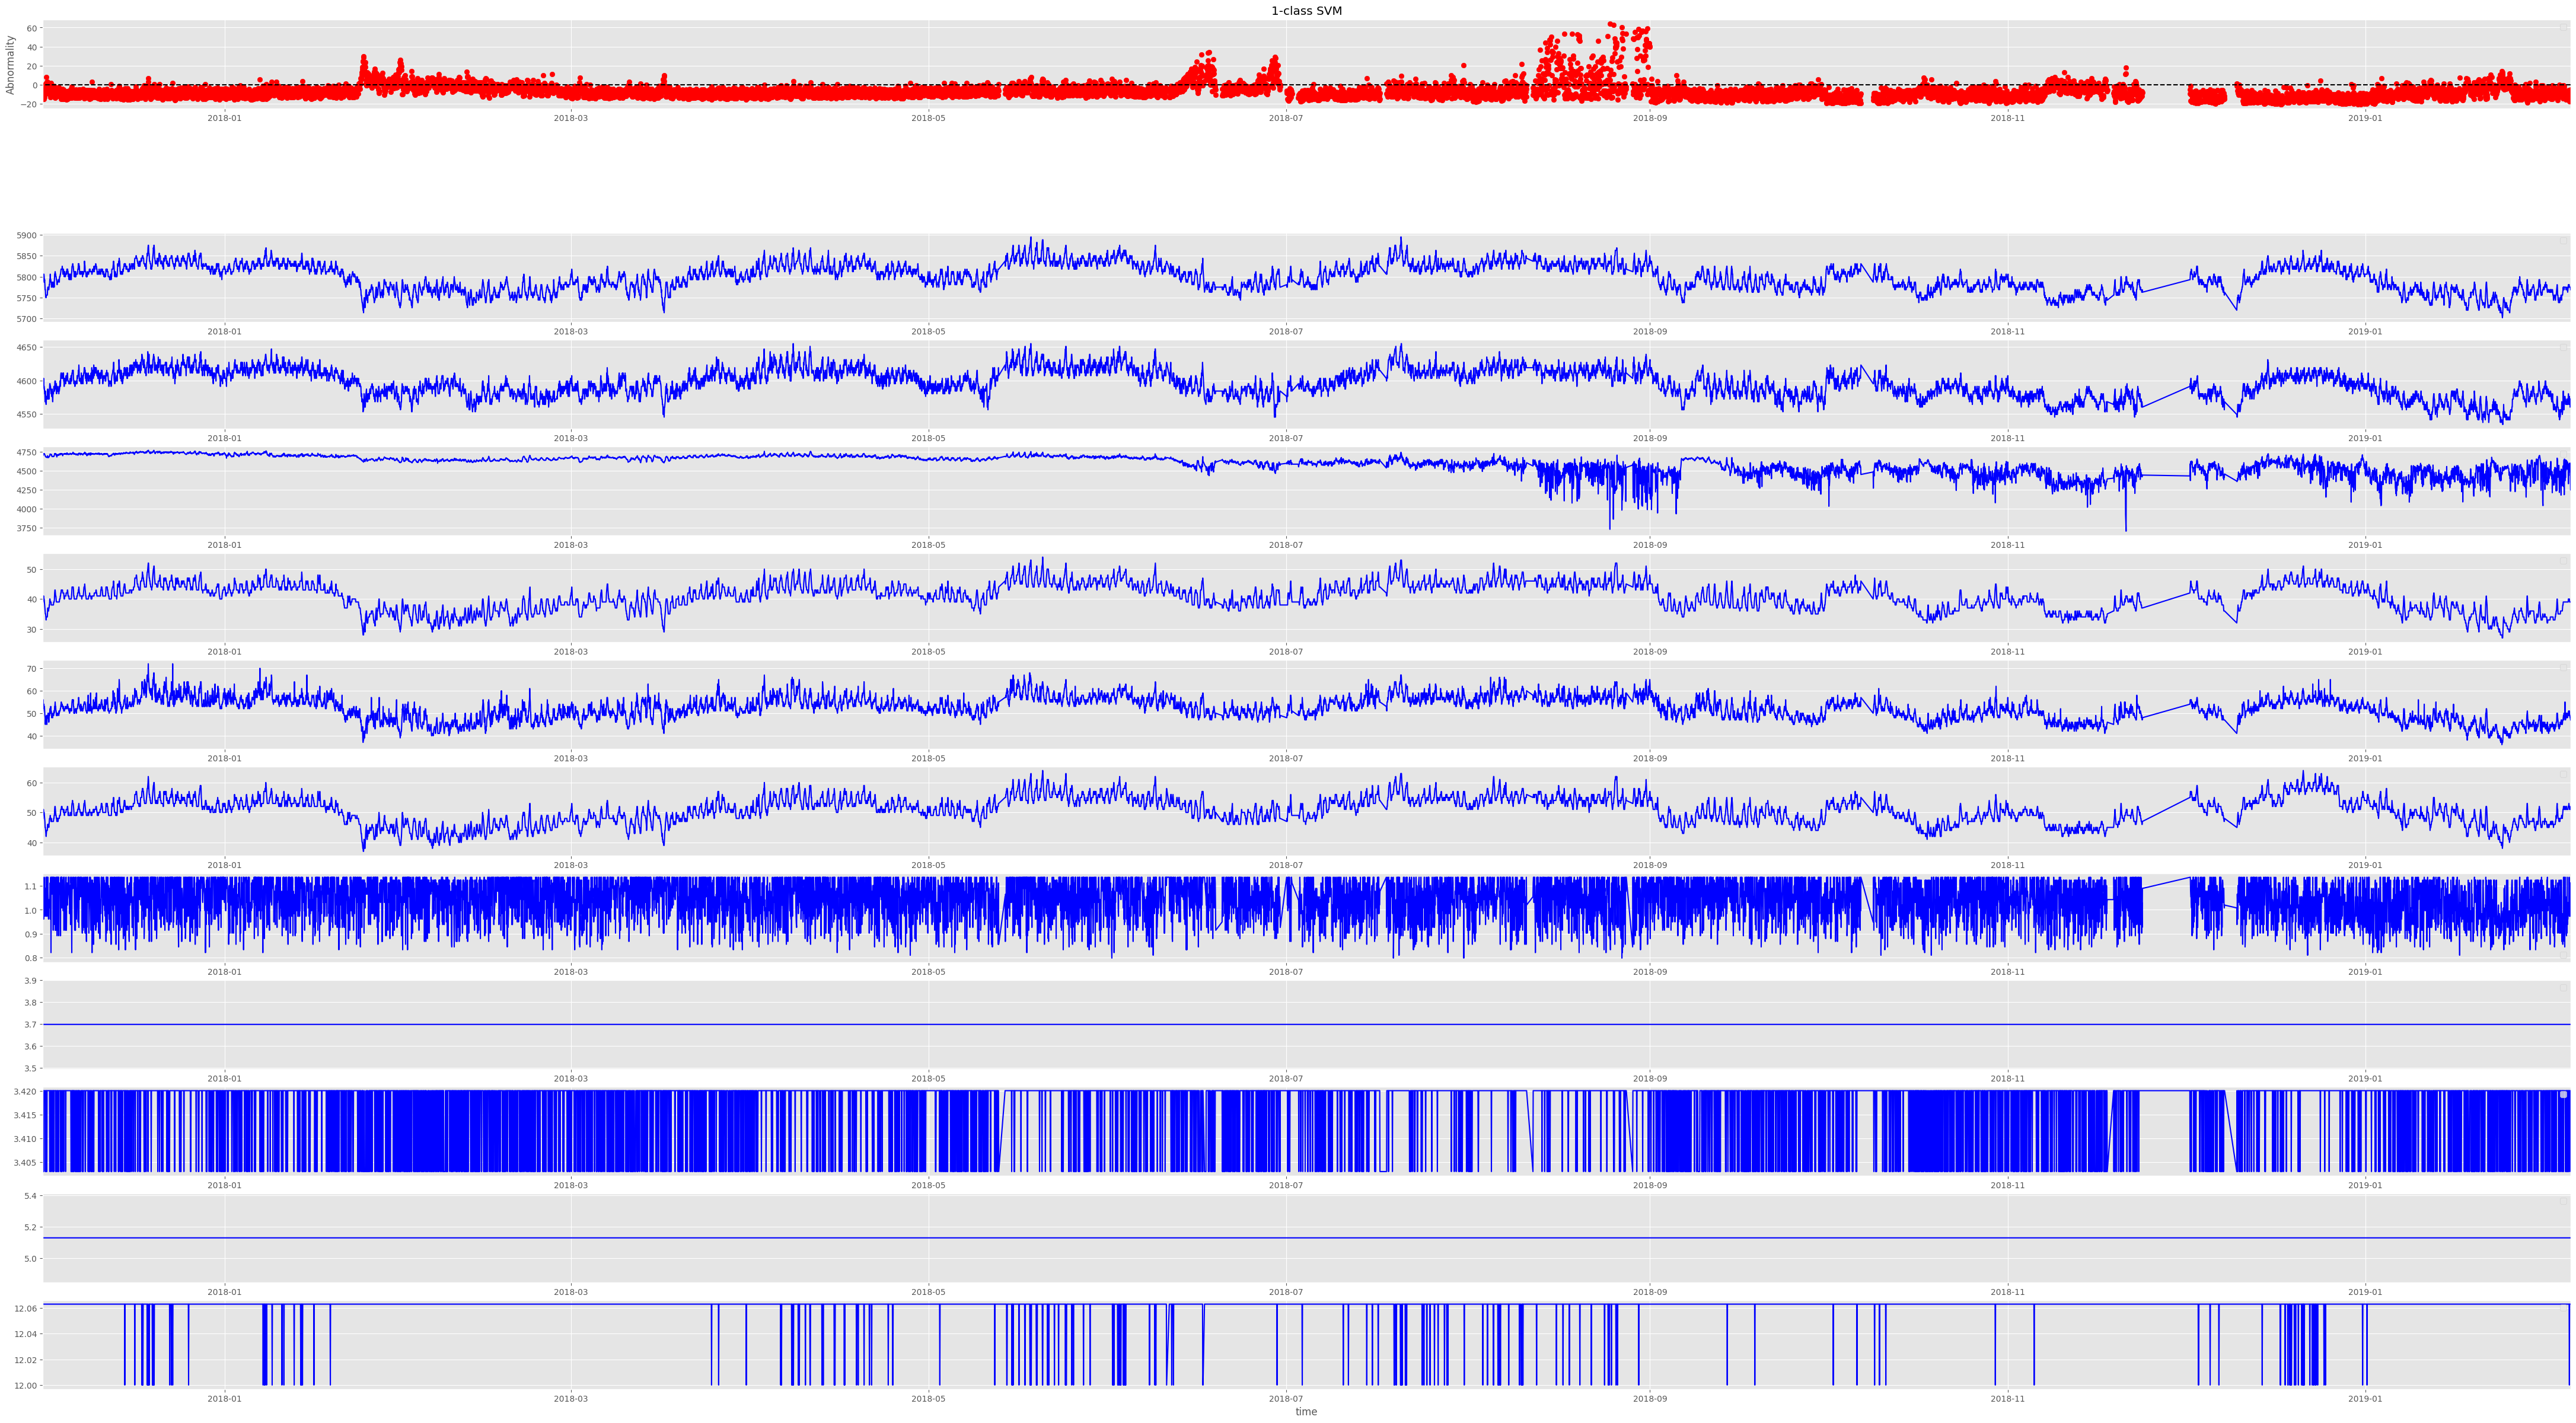

In [40]:
%%time
#現在時刻の取得
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore') 


time = pd.to_datetime(ans_data_set_no_cor["measurement_date"], format='%Y/%m/%d %H:%M:%S')

#異常スコアの出力
#図の大きさを指定
fig = plt.figure(figsize=(55,30))

#はじめのサブプロットの作成（異常スコア）
ax1 = fig.add_subplot(13,1,1)
ax1.set_title("1-class SVM")

#score_abnormal_OCSVMが異常スコアとして使用される
ax1.scatter(time,ans_data_set_no_cor["score_abnormal_OCSVM"], color='r')
ax1.set_ylabel('Abnormality')
#異常スコアの閾値ラインの設定
#異常スコアが０は丁度正常領域と異常領域の間にある。したがって０より大きい場合は異常データとみなされる。
ax1.hlines(0,time.max(),time.min(), color='black',linestyles='dashed')
ax1.set_xlim(time.min(),time.max())
ax1.legend()


# 元データの出力
# 元の特徴量の時系列ごとのデータ
for i, column in enumerate (colums_list):
    ax = fig.add_subplot(13,1,i+3)
    ax.plot(time,ans_data_set_no_cor[column], color='b')
    ax.set_xlabel('time')
    ax.set_xlim(time.min(),time.max())
    ax.legend()

print("データ数：",ans_data_set_no_cor["score_abnormal_OCSVM"].count())
print("1-class SVM異常検知個数：",ans_data_set_no_cor.query("score_abnormal_OCSVM>0")["score_abnormal_OCSVM"].count())
print("1-class SVM異常検知割合：{:.2%}".format(ans_data_set_no_cor.query("score_abnormal_OCSVM>0")["score_abnormal_OCSVM"].count()/ans_data_set_no_cor["score_abnormal_OCSVM"].count()))


異常データのみの出力

2024/08/08 16:15
CPU times: total: 15.6 ms
Wall time: 284 ms


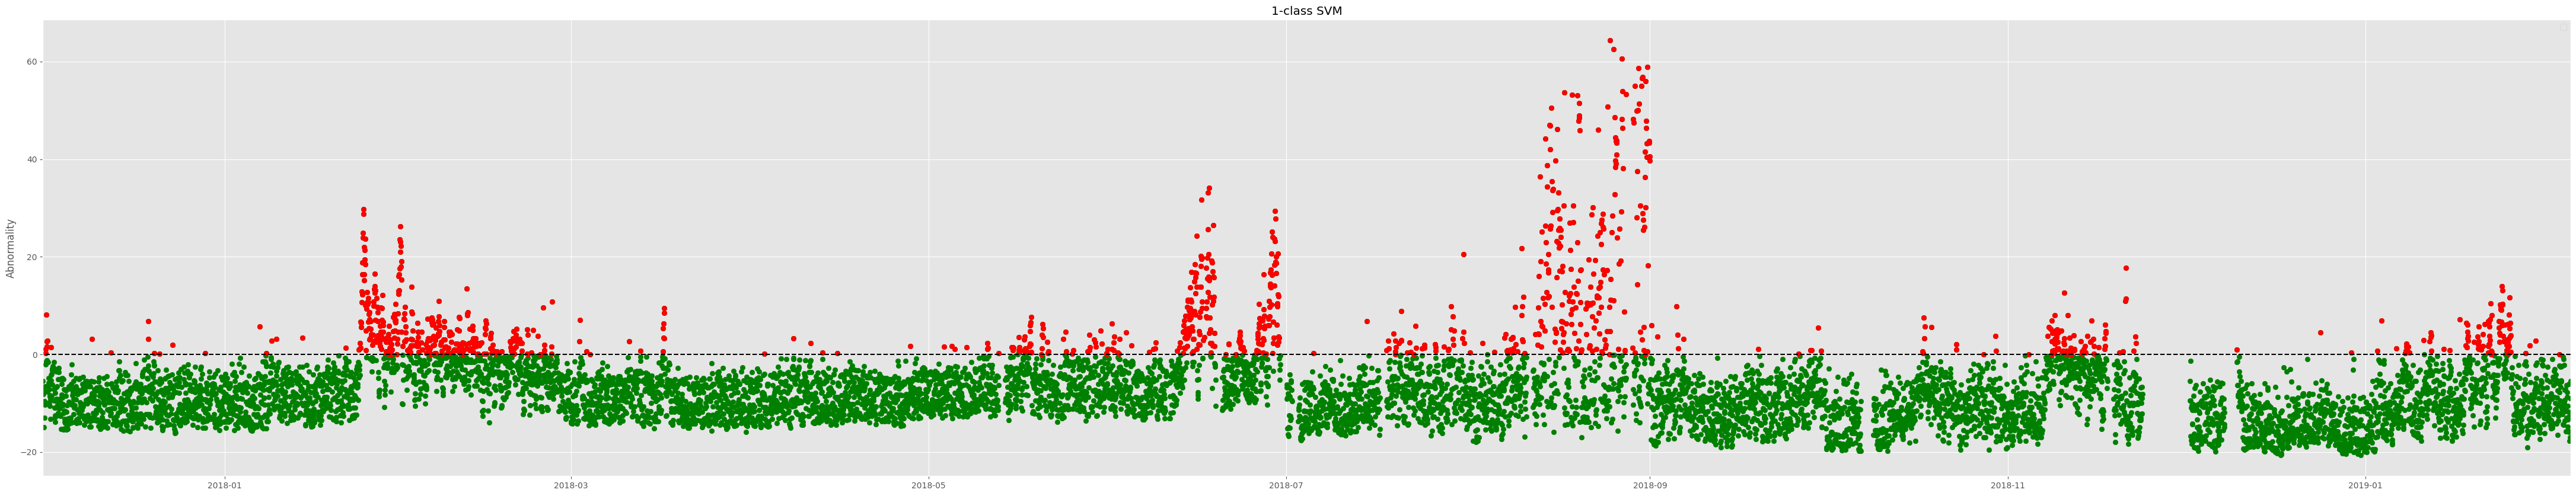

In [38]:
%%time
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore') 

time = pd.to_datetime(ans_data_set_no_cor["measurement_date"], format='%Y/%m/%d %H:%M:%S')


#異常データのみを抽出する(赤で表現するため)
select_OCSVM=ans_data_set_no_cor[ans_data_set_no_cor["score_abnormal_OCSVM"]>0]


time1 = pd.to_datetime(select_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')

fig = plt.figure(figsize=(55,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title("1-class SVM")
ax1.scatter(time,ans_data_set_no_cor["score_abnormal_OCSVM"], color='g')
ax1.scatter(time1,select_OCSVM["score_abnormal_OCSVM"], color='r')
ax1.set_ylabel('Abnormality')
ax1.hlines(0,time.max(),time.min(), color='black',linestyles='dashed')
ax1.set_xlim(time.min(),time.max())
ax1.legend()

